Please note that this tutorial assumes you are already familiar
with technical details of kESI implementation.  If you are not,
consider running its expanded version
`tutorial_four_spheres_basics_explained.ipynb` instead.

# Model

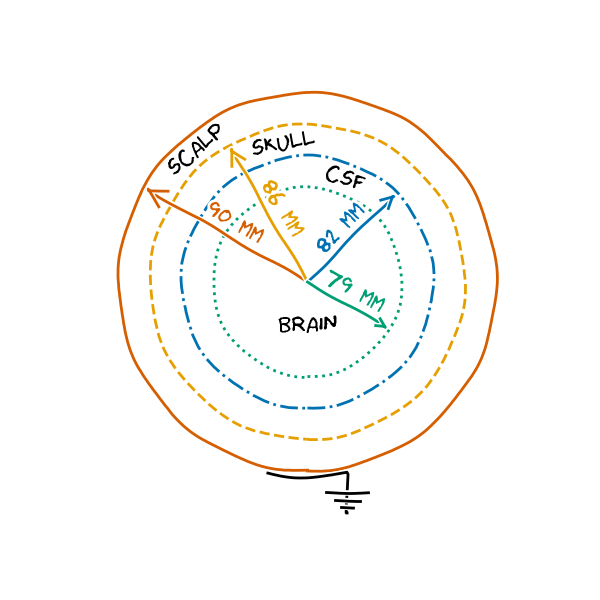

| Volume | Conductivity |
|:-------|:-------------|
| Scalp  |  330 mS / m  |
| Skull  | 16.5 mS / m  |
| CSF    | 1560 mS / m  |
| Brain  |  330 mS / m  |

# Requirements


## Environment

1. kESI installed normally into a python enviroment.
2. Jupyter server to run this notebooc.
3. gmsh to generate meshes, installed using pypi or using your favorite installer.


## Setup

### Mesh

You need to have a mesh in .msh format format. We have prepared 4 spheres mesh templates in air with big grounding plate and in vaccuum with a grounding electrode embedded in the spheres. The meshes have variants with 0.01, 0.005 and 0.005 mm maximum mesh element sizes. To generate MFEM readable mesh out of one of the templates use:

    cd extras/data/bundled/meshes
    mkdir -p ../../generated/meshes/
    gmsh -3 four_spheres_with_electrode_0.005.geo -o ../../generated/meshes/four_spheres_with_electrode_0.005.msh
    cd ../../../

The meshes contain 4 or 5 numbered materials, in order: brain, CSF, skull, scalp, air.

### Model properties

We are going to use following material conductivities.

+ Brain: 0.33 S/m
+ CSF: 1.65 S/m
+ skull bone: 0.0165 S/m
+ scalp 0.33 S/m
+ air 1e-10 S/m

### Electrodes

Lets define positions of three point electrodes:

    NAME,X,Y,Z
    first,0,0,0.0785
    second,0.01,0,0.07
    third,0.01,0.01,0.07

Write the positions as `data/generated/tutorial/four_spheres/tutorial_electrodes.csv`:

   ```
mkdir -p data/generated/tutorial/four_spheres/
nano data/generated/tutorial/four_spheres/tutorial_electrodes.csv
```

# Preprocessing

## Calculation of the leadfield correction

For every electrode we use Finite Element Method (FEM) to calculate the leadfield correction:

    mkdir -p data/generated/tutorial/four_spheres/mfem_leadfield_corrections
    kesi_mfem_piecewise_solver data/generated/meshes/four_spheres_with_electrode_0.005.msh \
    data/generated/tutorial/four_spheres/tutorial_electrodes.csv \
    data/generated/tutorial/four_spheres/mfem_leadfield_corrections \
    -bp 0 \
    -c 0.33 1.65 0.0165 0.33 1e-10 \
    --additional-refinement

This will create a .vtk file which contains the final mesh, leadfield correction and electrode leadfield (assuming electrodes are point charges).
It's possible to preview the solution with any industry standard viewer, for example `paraview`.

# Sampling of the leadfield correction

To use the correction field with kESI, it needs to be resampled into a uniform grid.

We sample the correction on NxNxN grid, where `N = 2**K + 1` and `K = 8`:

    mkdir -p data/generated/tutorial/four_spheres/mfem_sampled_leadfield_corrections
    python create_grid.py \
      --grid data/generated/tutorial/four_spheres/mfem_leadfield_correction_grid.npz \
      --start -0.1 \
      --end 0.1 \
      -k 8

    kesi_vista_resampling data/generated/tutorial/four_spheres/mfem_leadfield_corrections/four_spheres_with_electrode_0.005.vtk \
    data/generated/tutorial/four_spheres/tutorial_electrodes.csv \
    data/generated/tutorial/four_spheres/mfem_sampled_leadfield_corrections_vacuum \
    --attribute correction \
    -g data/generated/tutorial/four_spheres/mfem_leadfield_correction_grid.npz \
    --nifti

Adding `--nifti` param also creates sampled solution in NiFti file format which can be viewed using any volumetric image data viewer like ITK-SNAP or 3DSlicer. The filenames will correspond to electrode names.

# Kernel construction tools

## Electrode object

In [1]:
from kesi.kernel.electrode import LinearlyInterpolatedLeadfieldCorrection as Electrode
# # The interpolation can be speeded up at the cost of precision by changing
# # the class to `NearestNeighbourInterpolatedLeadfieldCorrection`:
# from kesi.kernel.electrode import NearestNeighbourInterpolatedLeadfieldCorrection as Electrode

In [2]:
electrodes = [Electrode(f"data/generated/tutorial/four_spheres/mfem_sampled_leadfield_corrections_vacuum/{name}.npz")
              for name in ["first", "second", "third"]]

In [3]:
#electrodes = [Electrode(f"data/generated/tutorial/four_spheres/mfem_sampled_leadfield_corrections_vacuum/{name}.npz")
#              for name in ["first", "second", "third"]]

## Model source

We want to use CSD basis functions 18mm wide ($R = 9mm$).

In [4]:
from kesi.common import SphericalSplineSourceKCSD


def get_model_source(radius):
    spline_nodes = [radius / 3, radius]
    spline_polynomial_coefficients = [[1],
                                      [0,
                                       6.75 / radius,
                                       -13.5 / radius ** 2,
                                       6.75 / radius ** 3]]
    return SphericalSplineSourceKCSD(0, 0, 0,
                                     spline_nodes,
                                     spline_polynomial_coefficients)

In [5]:
SRC_R = 9e-3

model_src = get_model_source(SRC_R)

## Convolver object

In [6]:
import numpy as np

from kesi.kernel.constructor import Convolver

BRAIN_RADIUS = 0.079
ROMBERG_K = 6

_h_min = SRC_R * 2**(1 - ROMBERG_K)
_n_xy = int(np.floor(2 * BRAIN_RADIUS / _h_min)) + 1
_n_z = int(np.floor((BRAIN_RADIUS + SRC_R) / _h_min)) + 1

_X = _Y = np.linspace(-BRAIN_RADIUS, BRAIN_RADIUS, _n_xy)
_Z = np.linspace(-SRC_R, BRAIN_RADIUS, _n_z)

_pot_grid = [_X, _Y, _Z]
_csd_grid = [_X, _Y, _Z[_Z >= 0]]

convolver = Convolver(_pot_grid, _csd_grid)

## Convolver interface

We include only CSD bases which supports fit in the brain<!--
and which centroid lies in the upper hemisphere-->.

In [7]:
from scipy.integrate import romb

from kesi.kernel.constructor import ConvolverInterfaceIndexed


ROMBERG_N = 2**ROMBERG_K + 1
ROMBERG_WEIGHTS = romb(np.identity(ROMBERG_N),
                       dx=2**-ROMBERG_K)

SRC_MASK = ((convolver.SRC_Z > SRC_R - 0.5 * BRAIN_RADIUS)
            & (np.sqrt(np.square(convolver.SRC_X)
                       + np.square(convolver.SRC_Y)
                       + np.square(convolver.SRC_Z)) < BRAIN_RADIUS - SRC_R))

In [8]:
print(SRC_MASK.sum())

32189168


In [9]:
convolver_interface = ConvolverInterfaceIndexed(convolver,
                                                model_src.csd,
                                                ROMBERG_WEIGHTS,
                                                SRC_MASK)

## Potential Basis Functions object

### Potential Basis Functions: analytical solution of the forward problem (kCSD)

In [10]:
import kesi.kernel.potential_basis_functions as pbf

In [11]:
pbf_kcsd = pbf.Analytical(convolver_interface,
                          potential=model_src.potential)

### Potential Basis Functions: numerically corrected analytical solution of the forward problem (kESI)

In [12]:
pbf_kesi = pbf.AnalyticalCorrectedNumerically(convolver_interface,
                                              potential=model_src.potential)

## (Cross)kernel constructors

In [13]:
from kesi.kernel.constructor import KernelConstructor, CrossKernelConstructor

In [14]:
kernel_constructor = KernelConstructor()

In [15]:
CSD_MASK = np.ones(convolver.shape('CSD'),
                   dtype=bool)

In [16]:
kernel_constructor.crosskernel = CrossKernelConstructor(convolver_interface,
                                                        CSD_MASK)

In [17]:
def to_3D(CSD):
    return CSD.reshape(convolver.shape('CSD'))

# kCSD reconstructor

## Construction of kernels

In [18]:
%%time
B_KCSD = kernel_constructor.potential_basis_functions_at_electrodes(electrodes,
                                                                    pbf_kcsd)

CPU times: user 1.21 s, sys: 1.03 s, total: 2.24 s
Wall time: 2.23 s


In [19]:
KERNEL_KCSD = kernel_constructor.kernel(B_KCSD)

In [20]:
%%time
CROSSKERNEL_KCSD = kernel_constructor.crosskernel(B_KCSD)

CPU times: user 8.89 s, sys: 4.28 s, total: 13.2 s
Wall time: 13.2 s


In [21]:
del B_KCSD  # the array is large and no longer needed

## Reconstructor object

In [22]:
from kesi import Reconstructor

In [23]:
reconstructor_kcsd = Reconstructor(KERNEL_KCSD,
                                   CROSSKERNEL_KCSD)

# Visualisation

In [24]:
import matplotlib.pyplot as plt

from local import cbf
from local.tutorial.view import FourSpheres as CoordinatePlanesVisualisation

In [25]:
csd_plotter = CoordinatePlanesVisualisation(convolver.CSD_GRID,
                                            [0.01, 0, 0.065],
                                            unit_factor=1e-3,
                                            unit='$\\frac{pA}{mm^3}$',
                                            length_factor=1e3,
                                            length_unit='$mm$')

# Ground Truth CSD and its electric field

## GT CSD

In [26]:
from local.tutorial import eigh


EIGENVALUES_KCSD, EIGENVECTORS_KCSD = eigh(KERNEL_KCSD)

GT_CSD = 10 * to_3D(reconstructor_kcsd(EIGENVECTORS_KCSD[:, 0]))

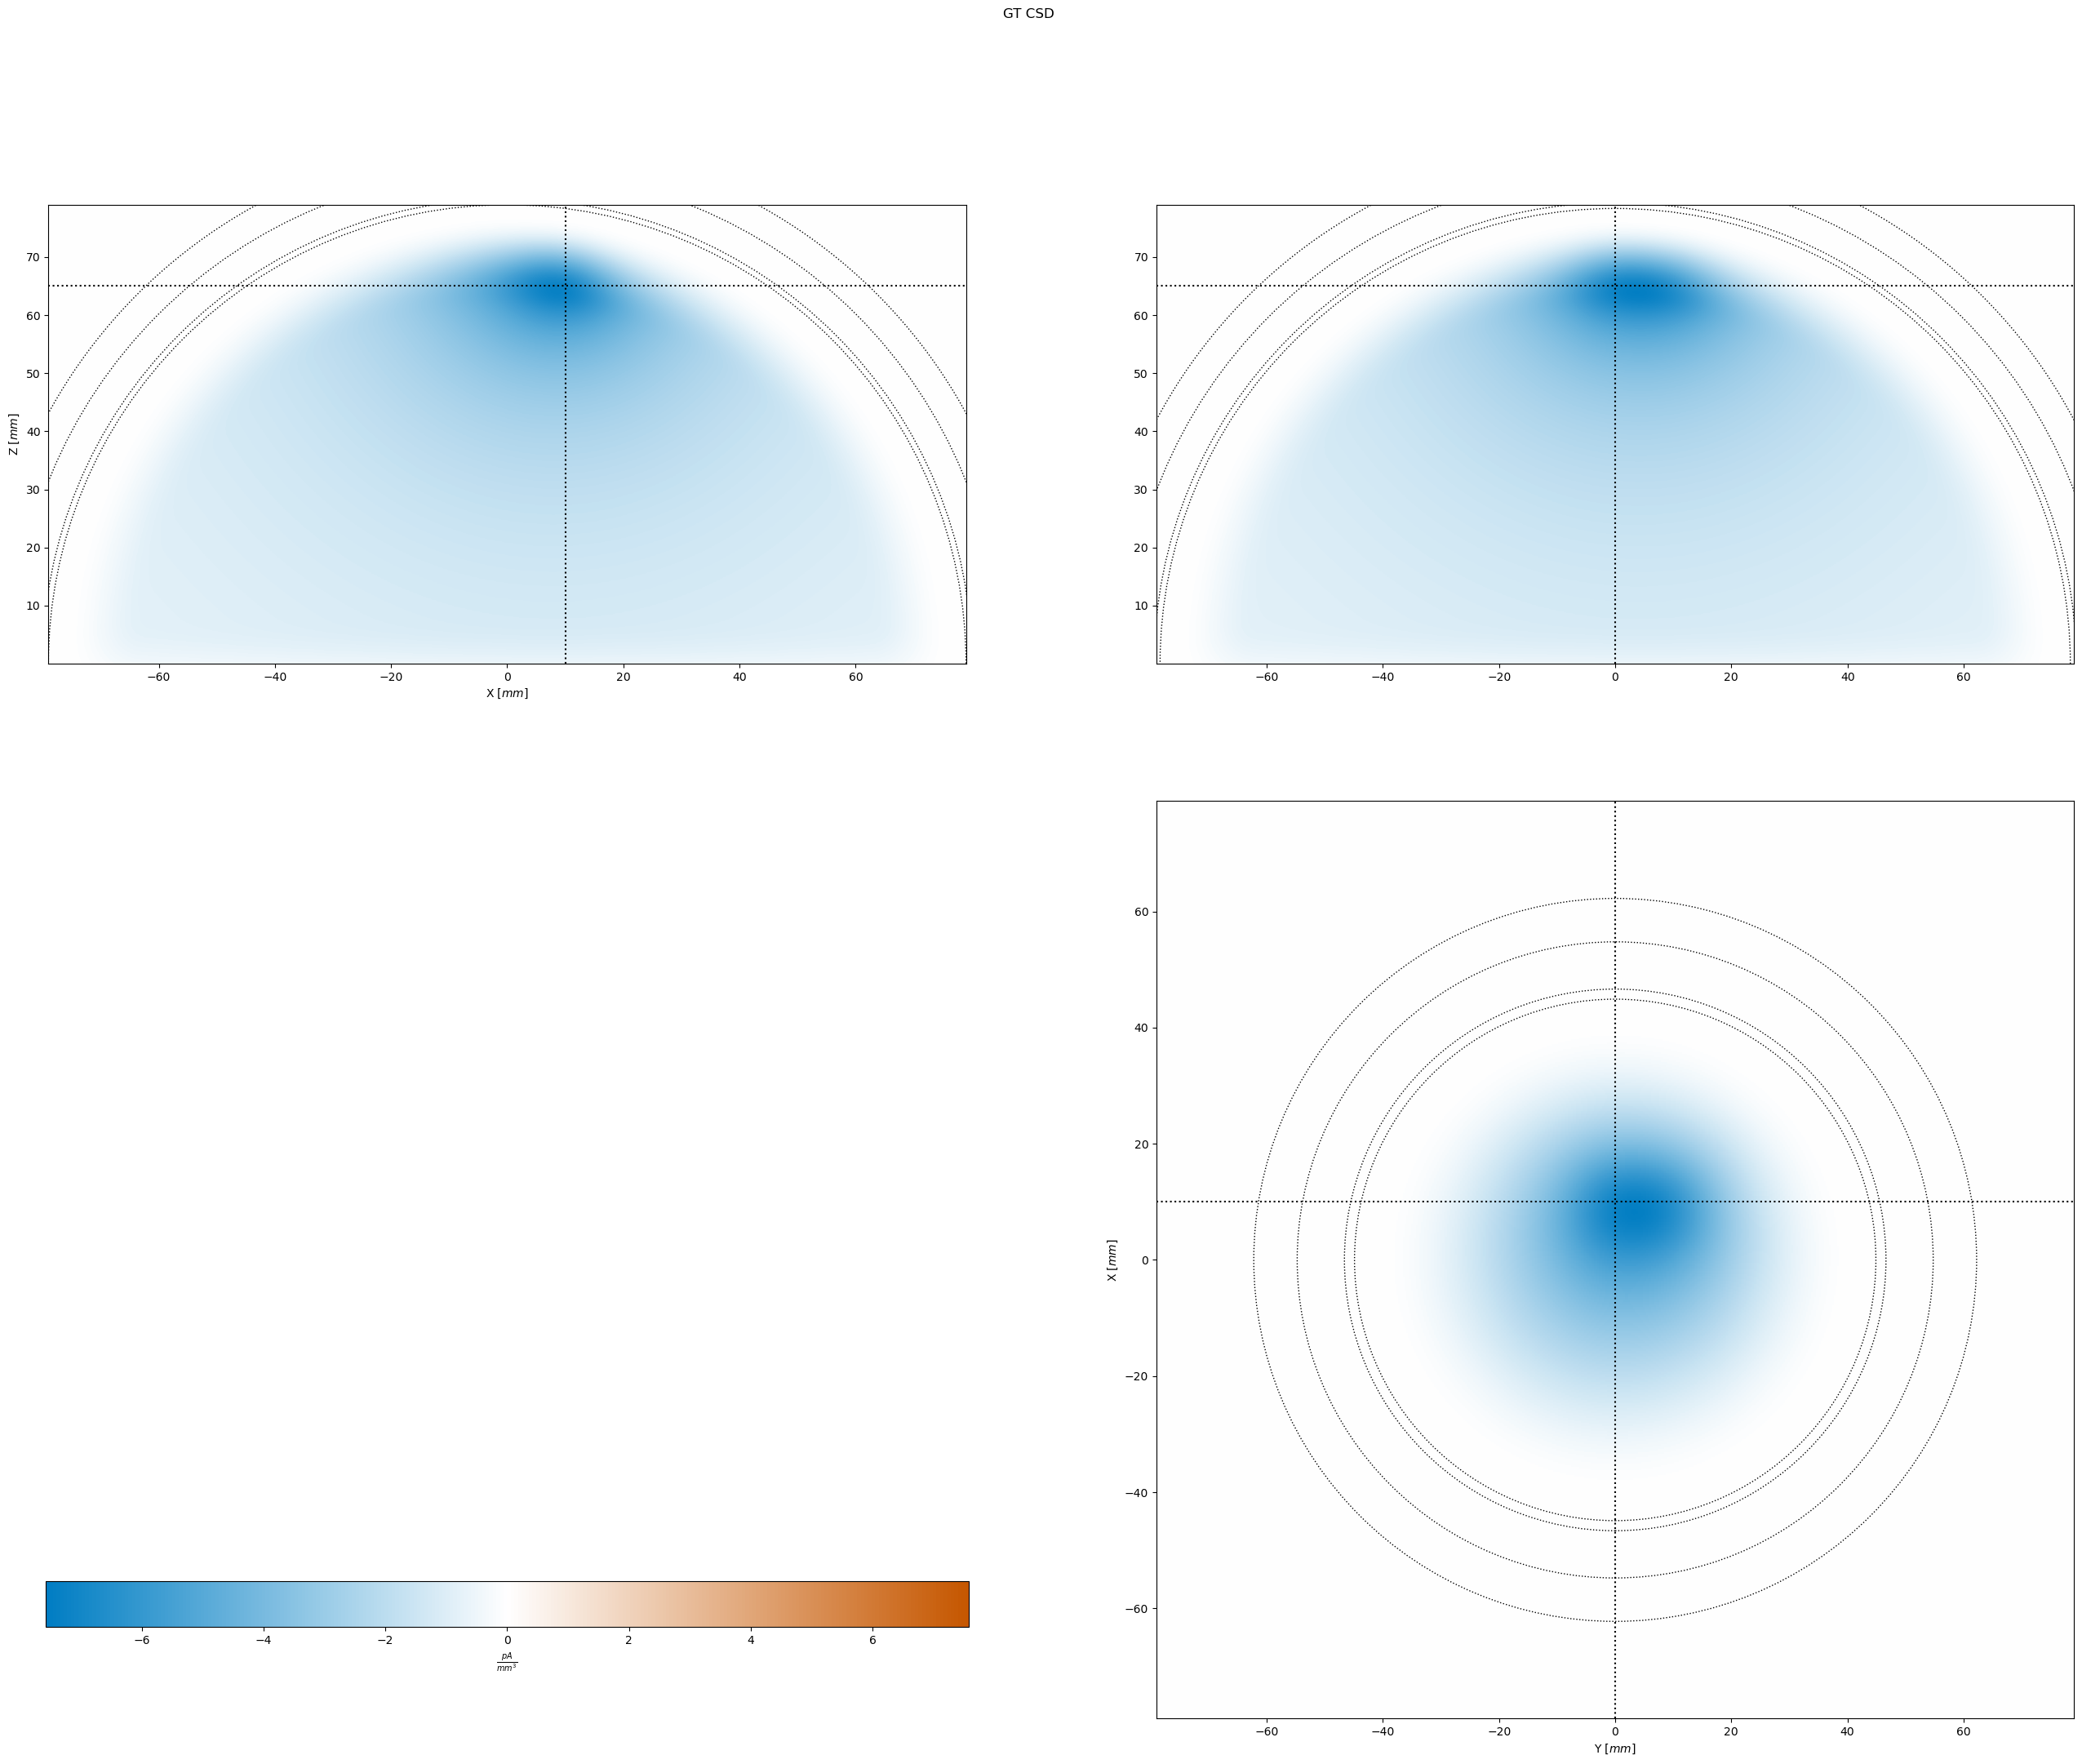

In [27]:
csd_plotter.plot_volume(GT_CSD, 'GT CSD')

## FEM forward modelling

In [28]:
import scipy.interpolate as si

from local.tutorial import SphericalForwardModel as ForwardModel

In [29]:
%%time
fem = ForwardModel("data/generated/meshes/four_spheres_csf_3_mm__plain/normal.xdmf",
                   1,
                   "data/bundled/model_properties/four_spheres_csf_3_mm__Naess_Chintaluri_2017.ini")

CPU times: user 111 ms, sys: 929 µs, total: 112 ms
Wall time: 109 ms


In [30]:
%%time
_csd_grid = [_x.flatten() for _x in convolver.CSD_GRID]
_csd = si.RegularGridInterpolator(_csd_grid,
                                  GT_CSD,
                                  bounds_error=False,
                                  fill_value=0)
potential = fem(_csd)

del _csd  # the object is large and no longer needed

CPU times: user 206 ms, sys: 545 ms, total: 752 ms
Wall time: 77.3 ms


We visualise the potential.

In [31]:
potential_plotter = CoordinatePlanesVisualisation(convolver.CSD_GRID,
                                                  [0.01, 0, 0.065],
                                                  unit='$\mu{}V$',
                                                  length_factor=1e3,
                                                  length_unit='$mm$',
                                                  cmap=cbf.PRGn)

Building point search tree to accelerate distance queries.
Computed bounding box tree with 112605 nodes for 56303 points.
CPU times: user 8.14 s, sys: 1.41 s, total: 9.55 s
Wall time: 7.86 s


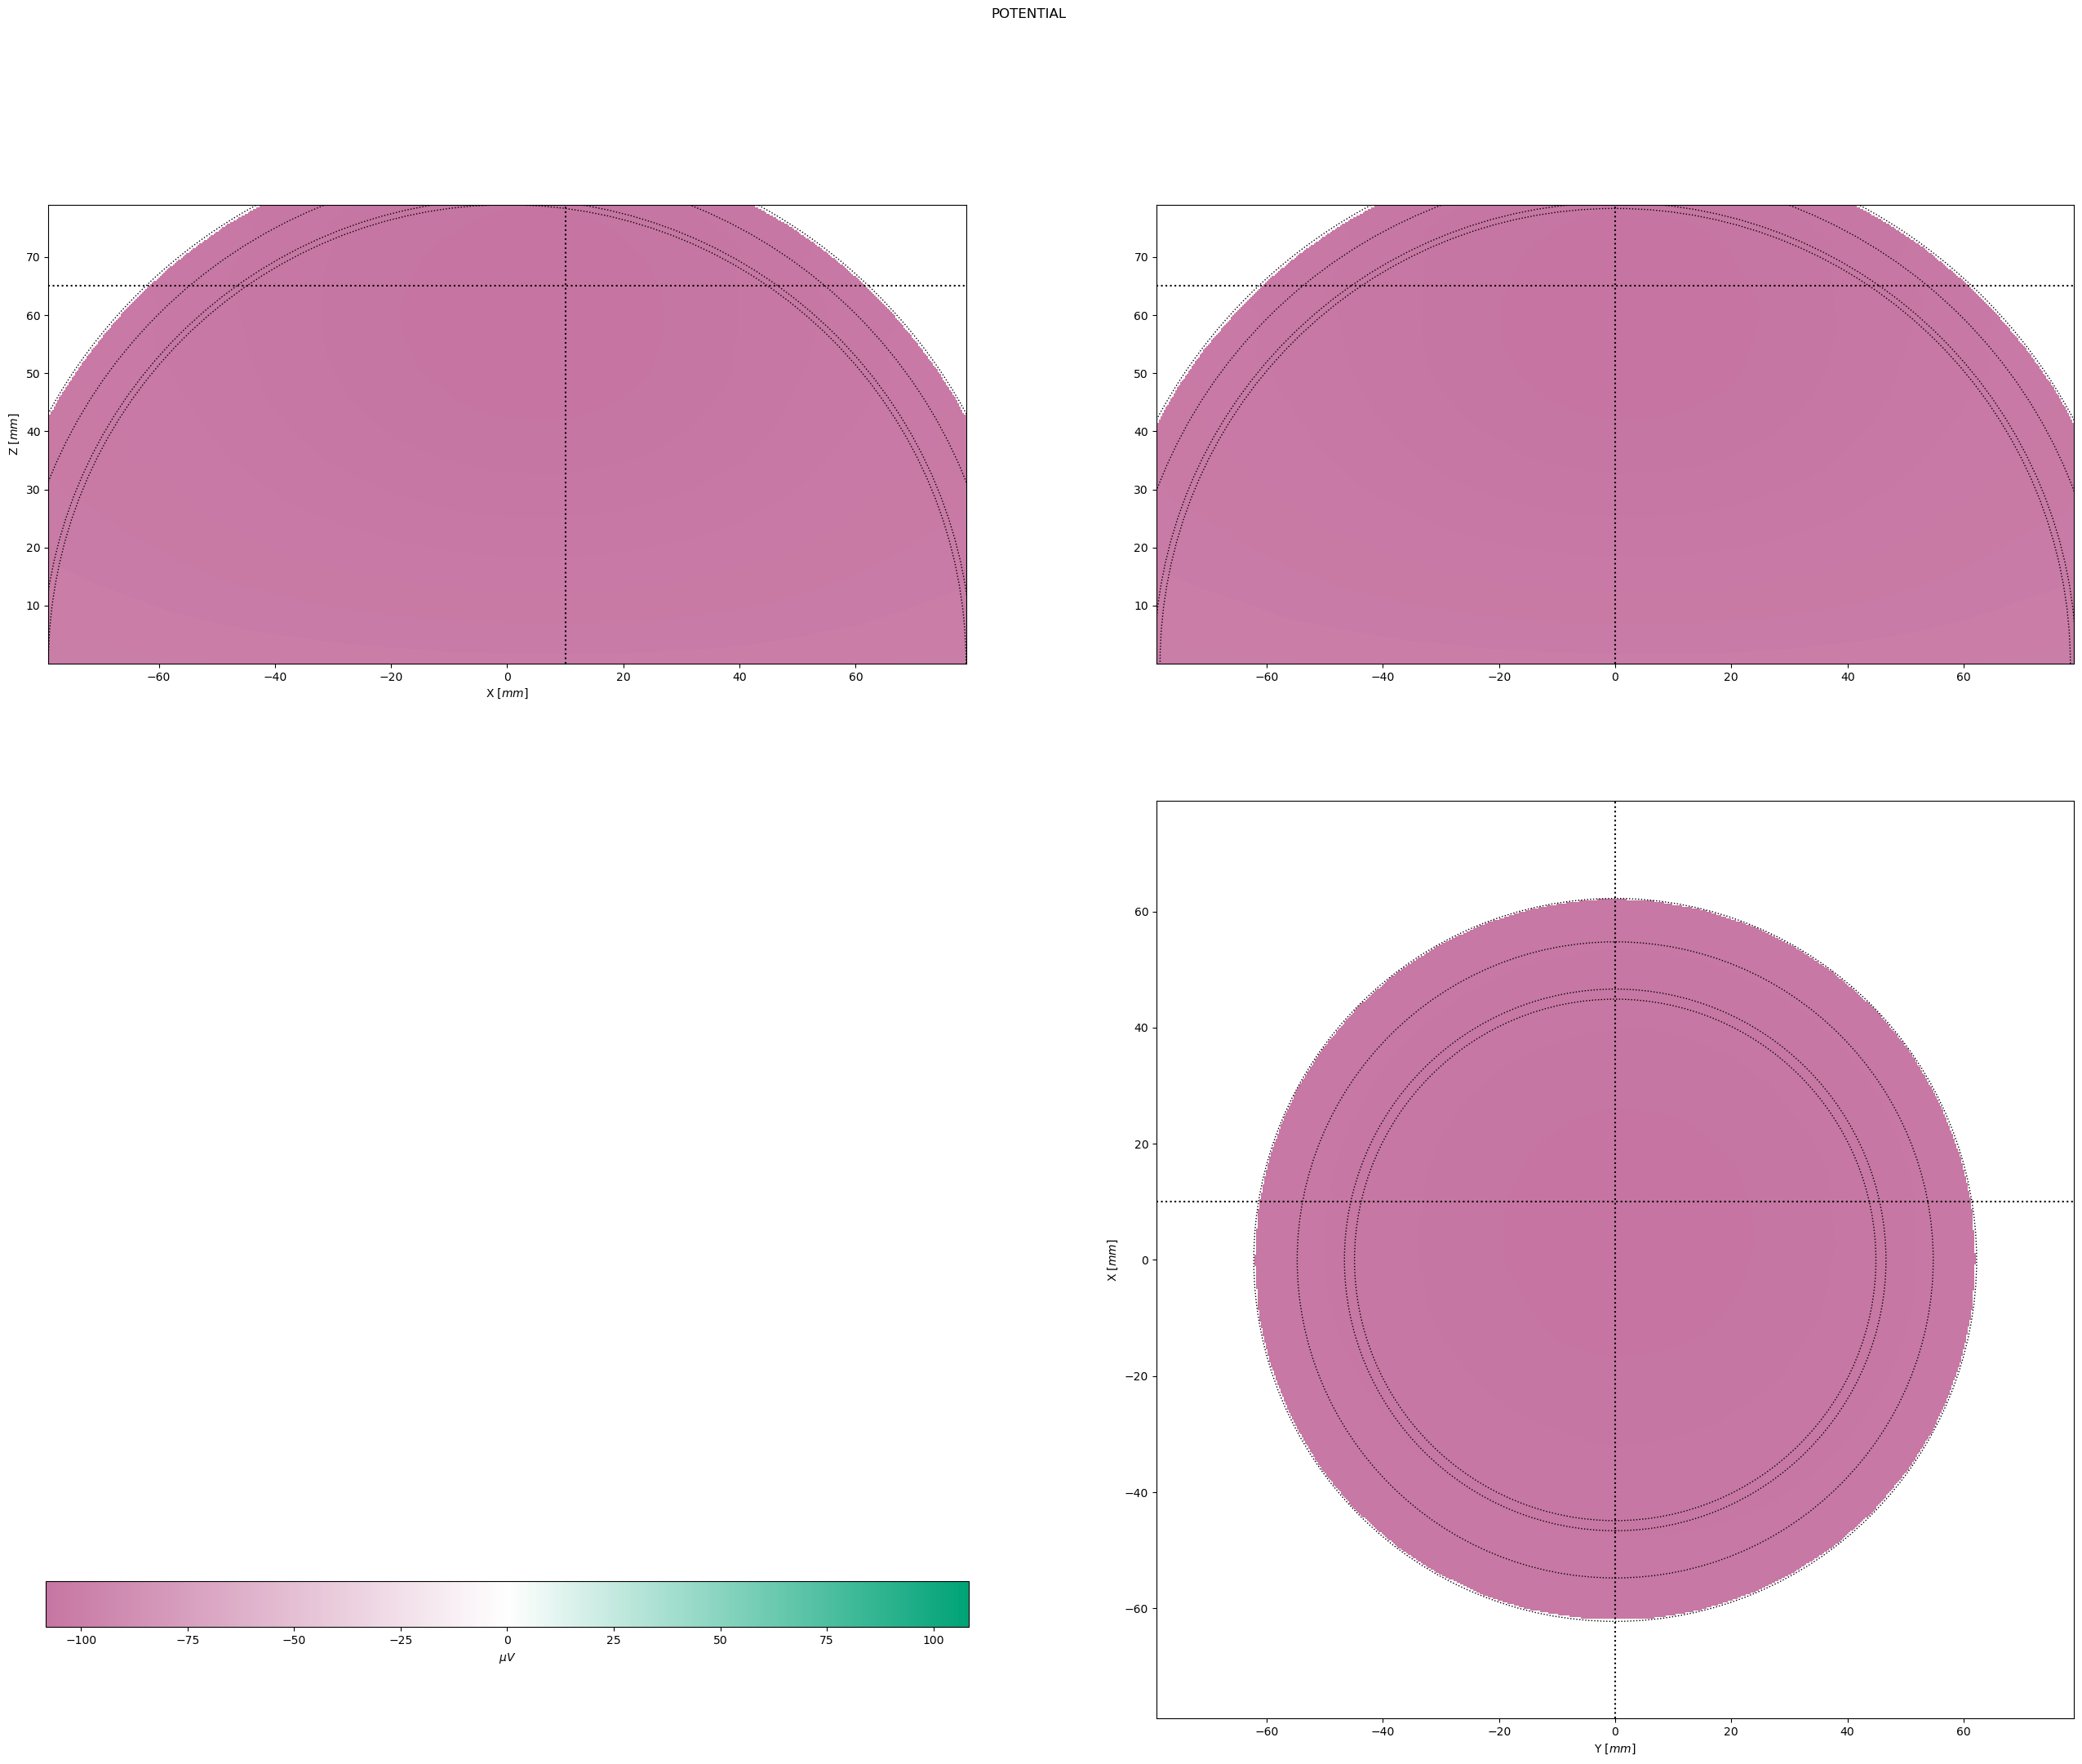

In [32]:
%%time
potential_plotter.plot_function(potential, 'POTENTIAL')

We probe the potential at electrodes.

In [33]:
GT_V = np.array([potential(_e.x, _e.y, _e.z) for _e in electrodes])

In [34]:
del potential, fem  # these objects are large and no longer needed

In [35]:
GT_V

array([-107.46257177, -107.97575919, -107.85987643])

# Reconstruction

## kCSD

In [36]:
CSD_KCSD = to_3D(reconstructor_kcsd(GT_V))

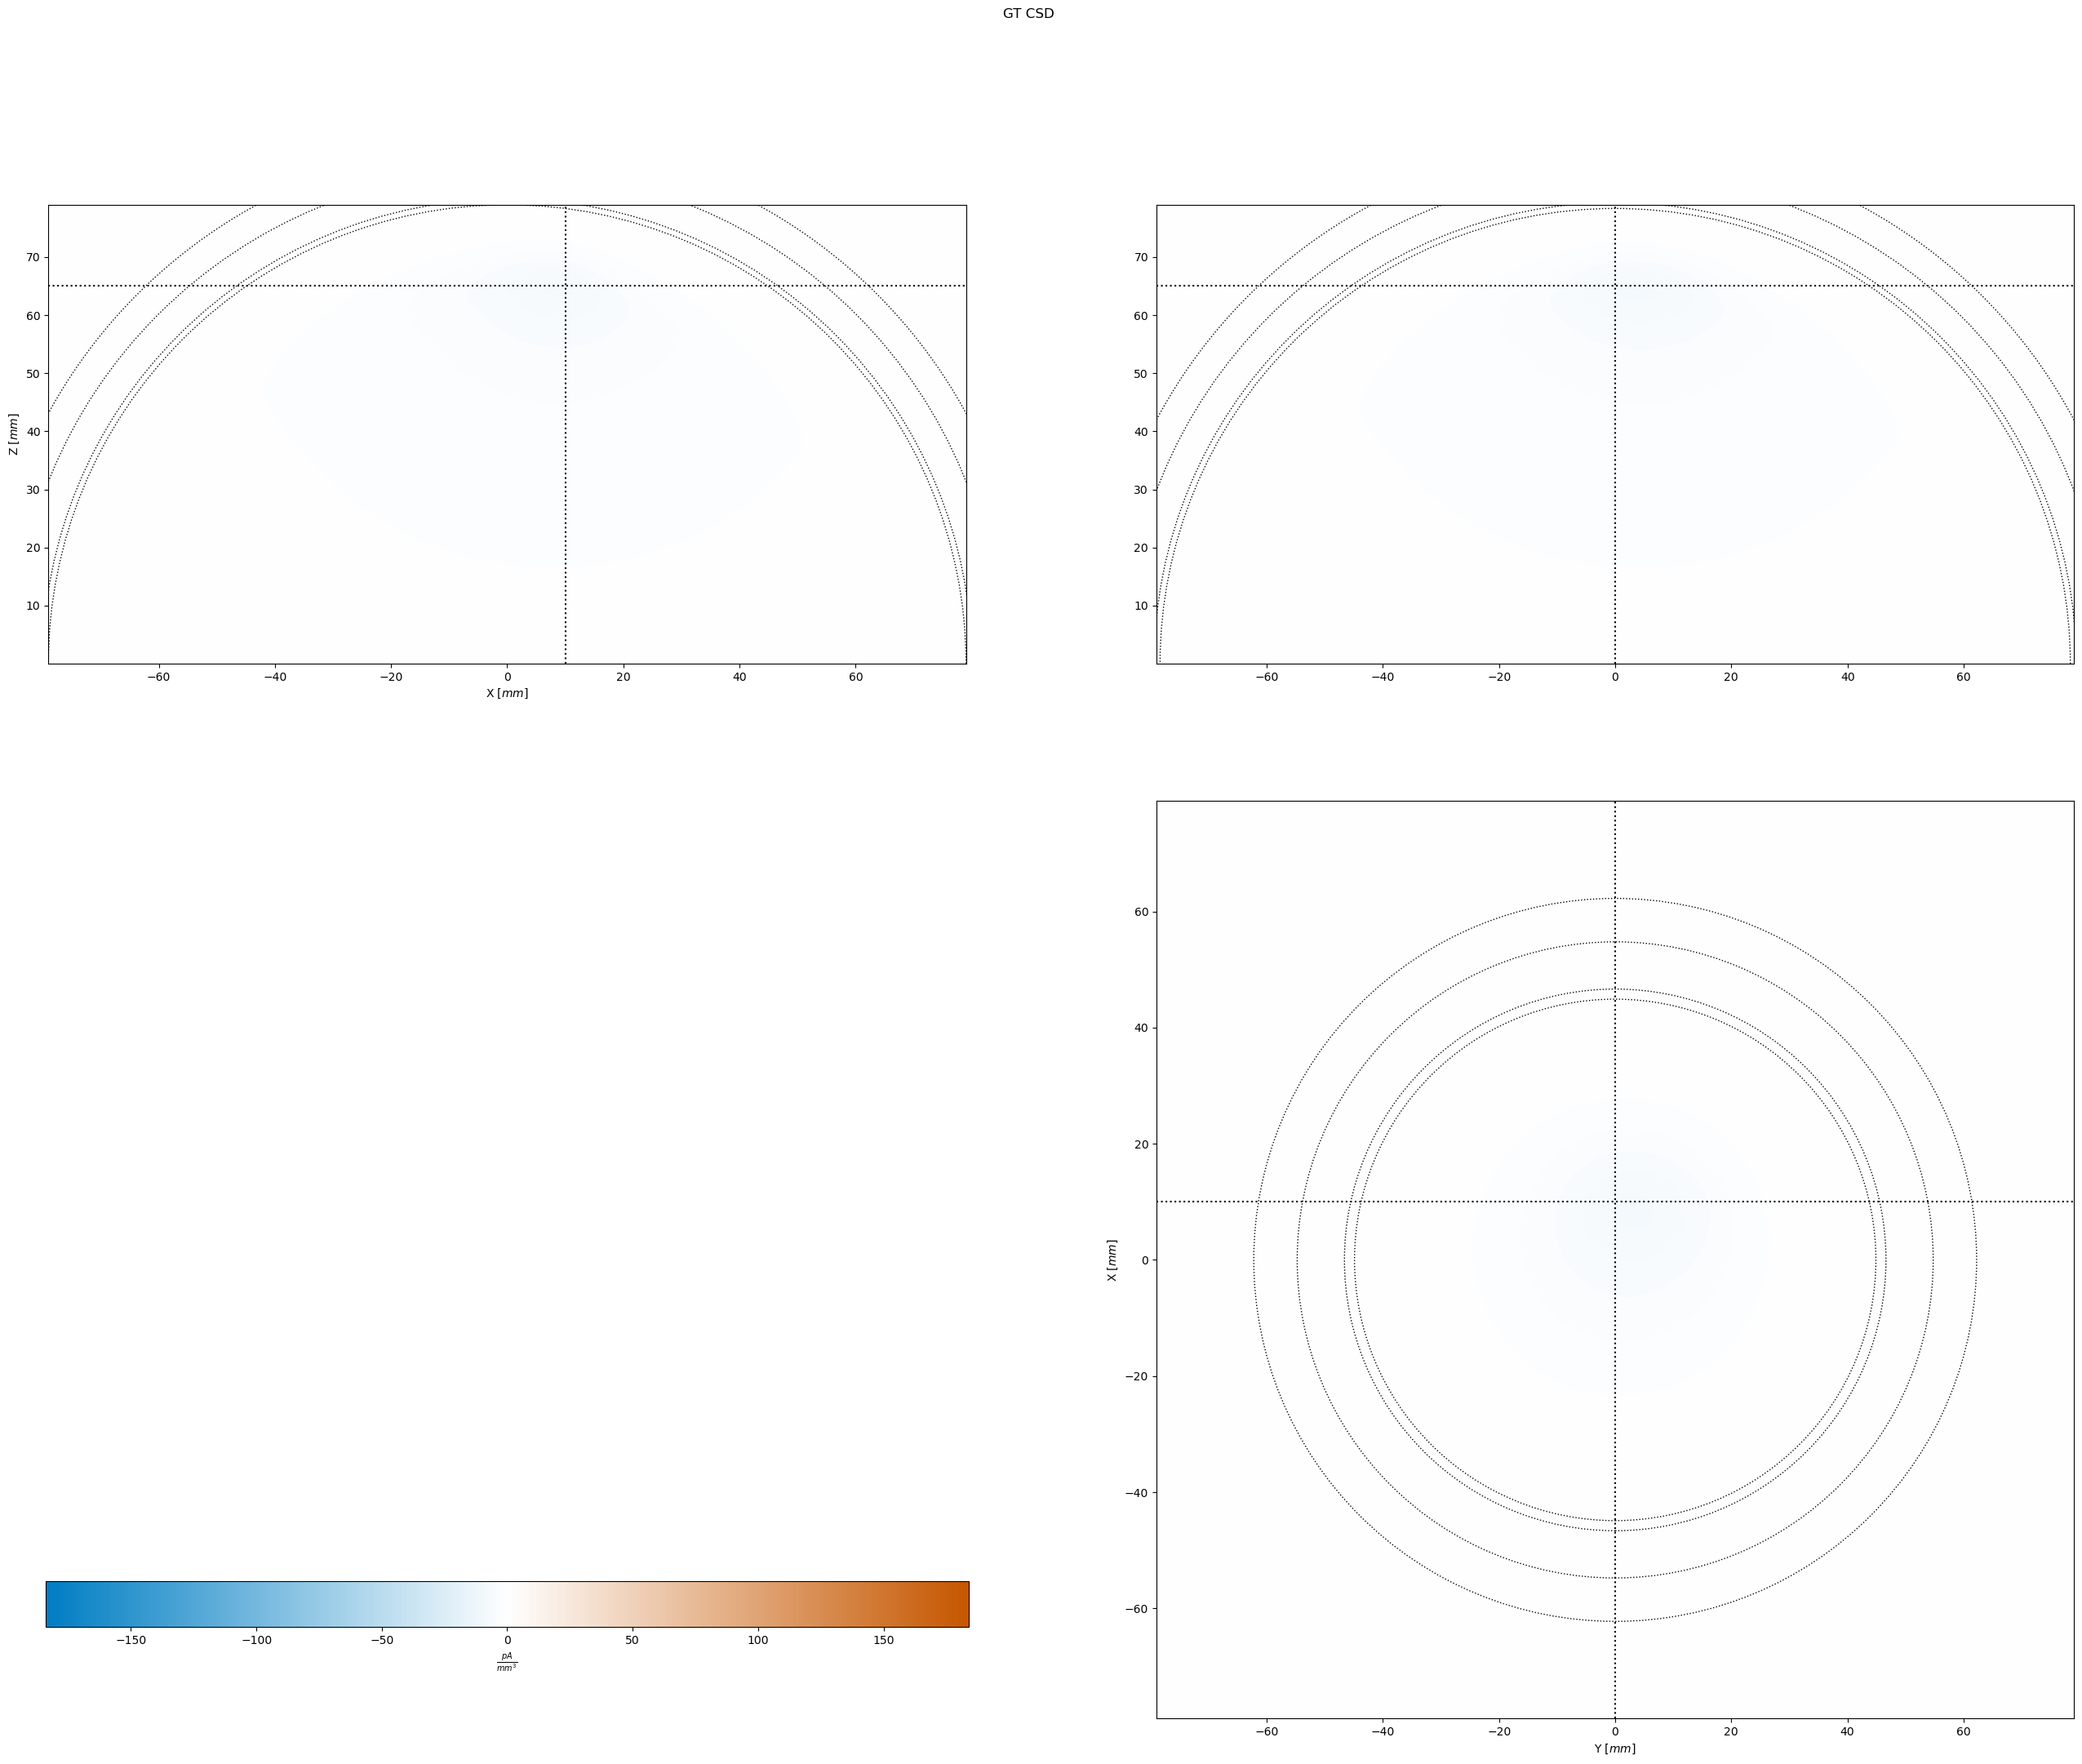

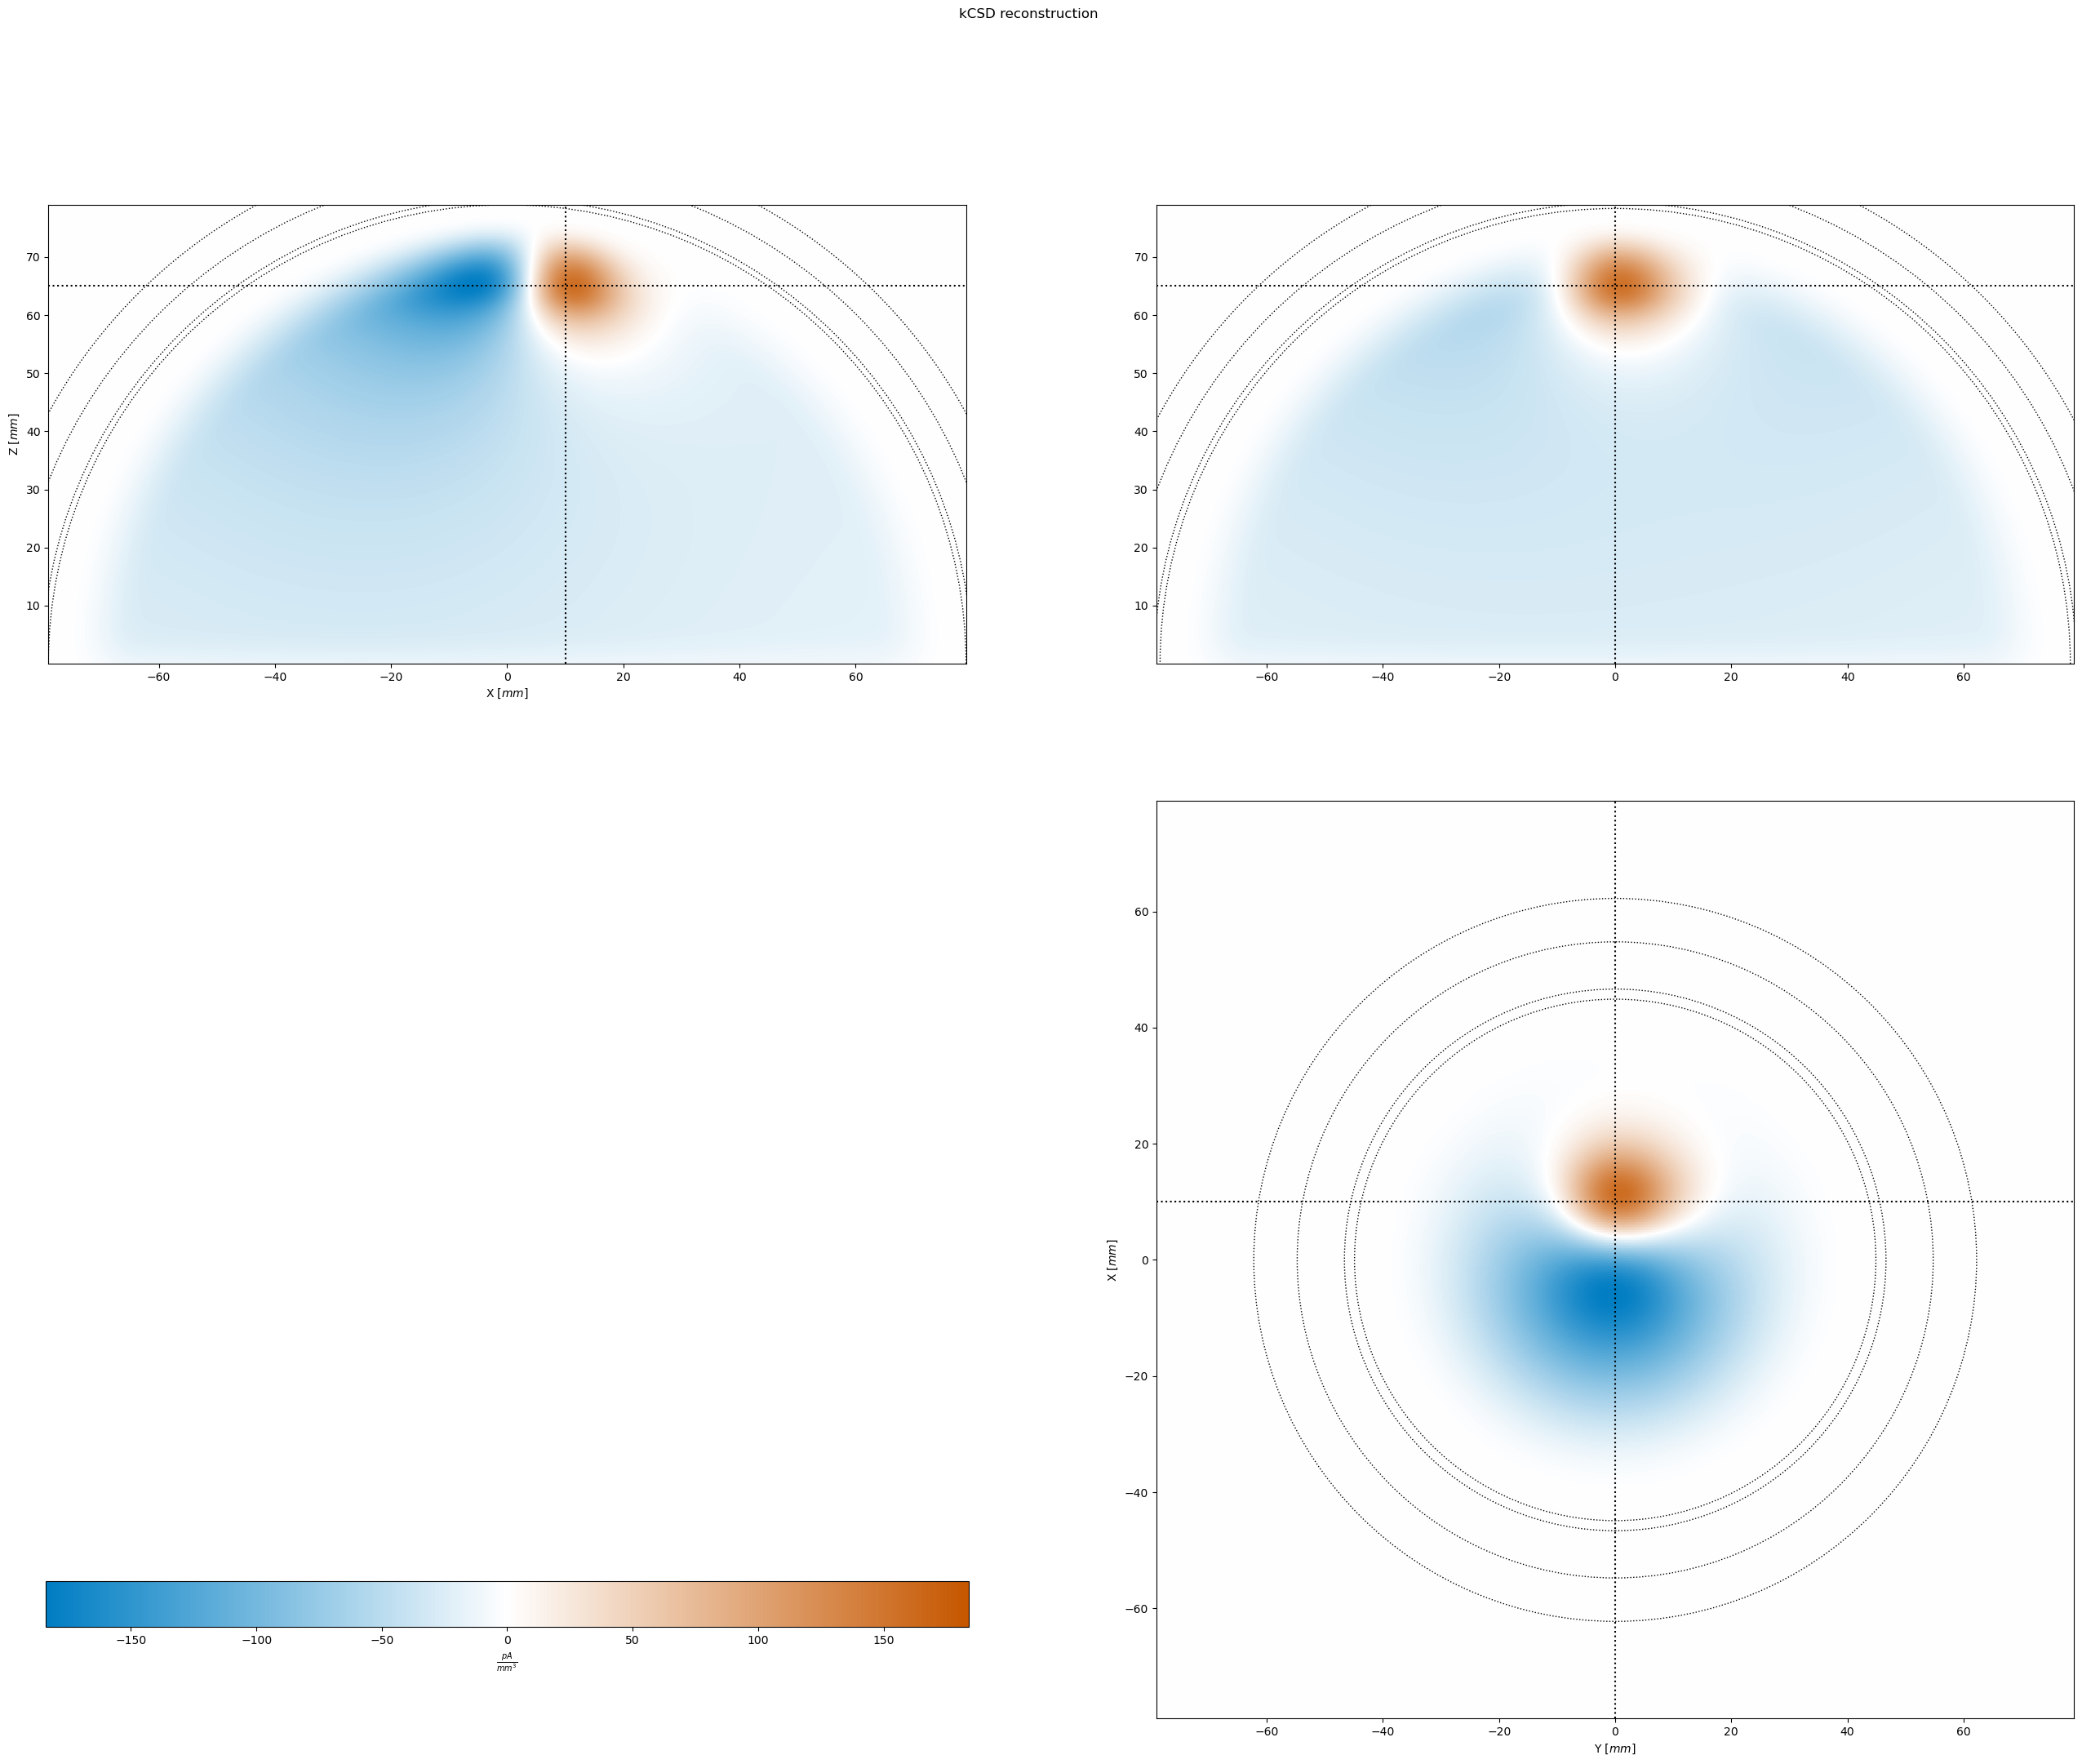

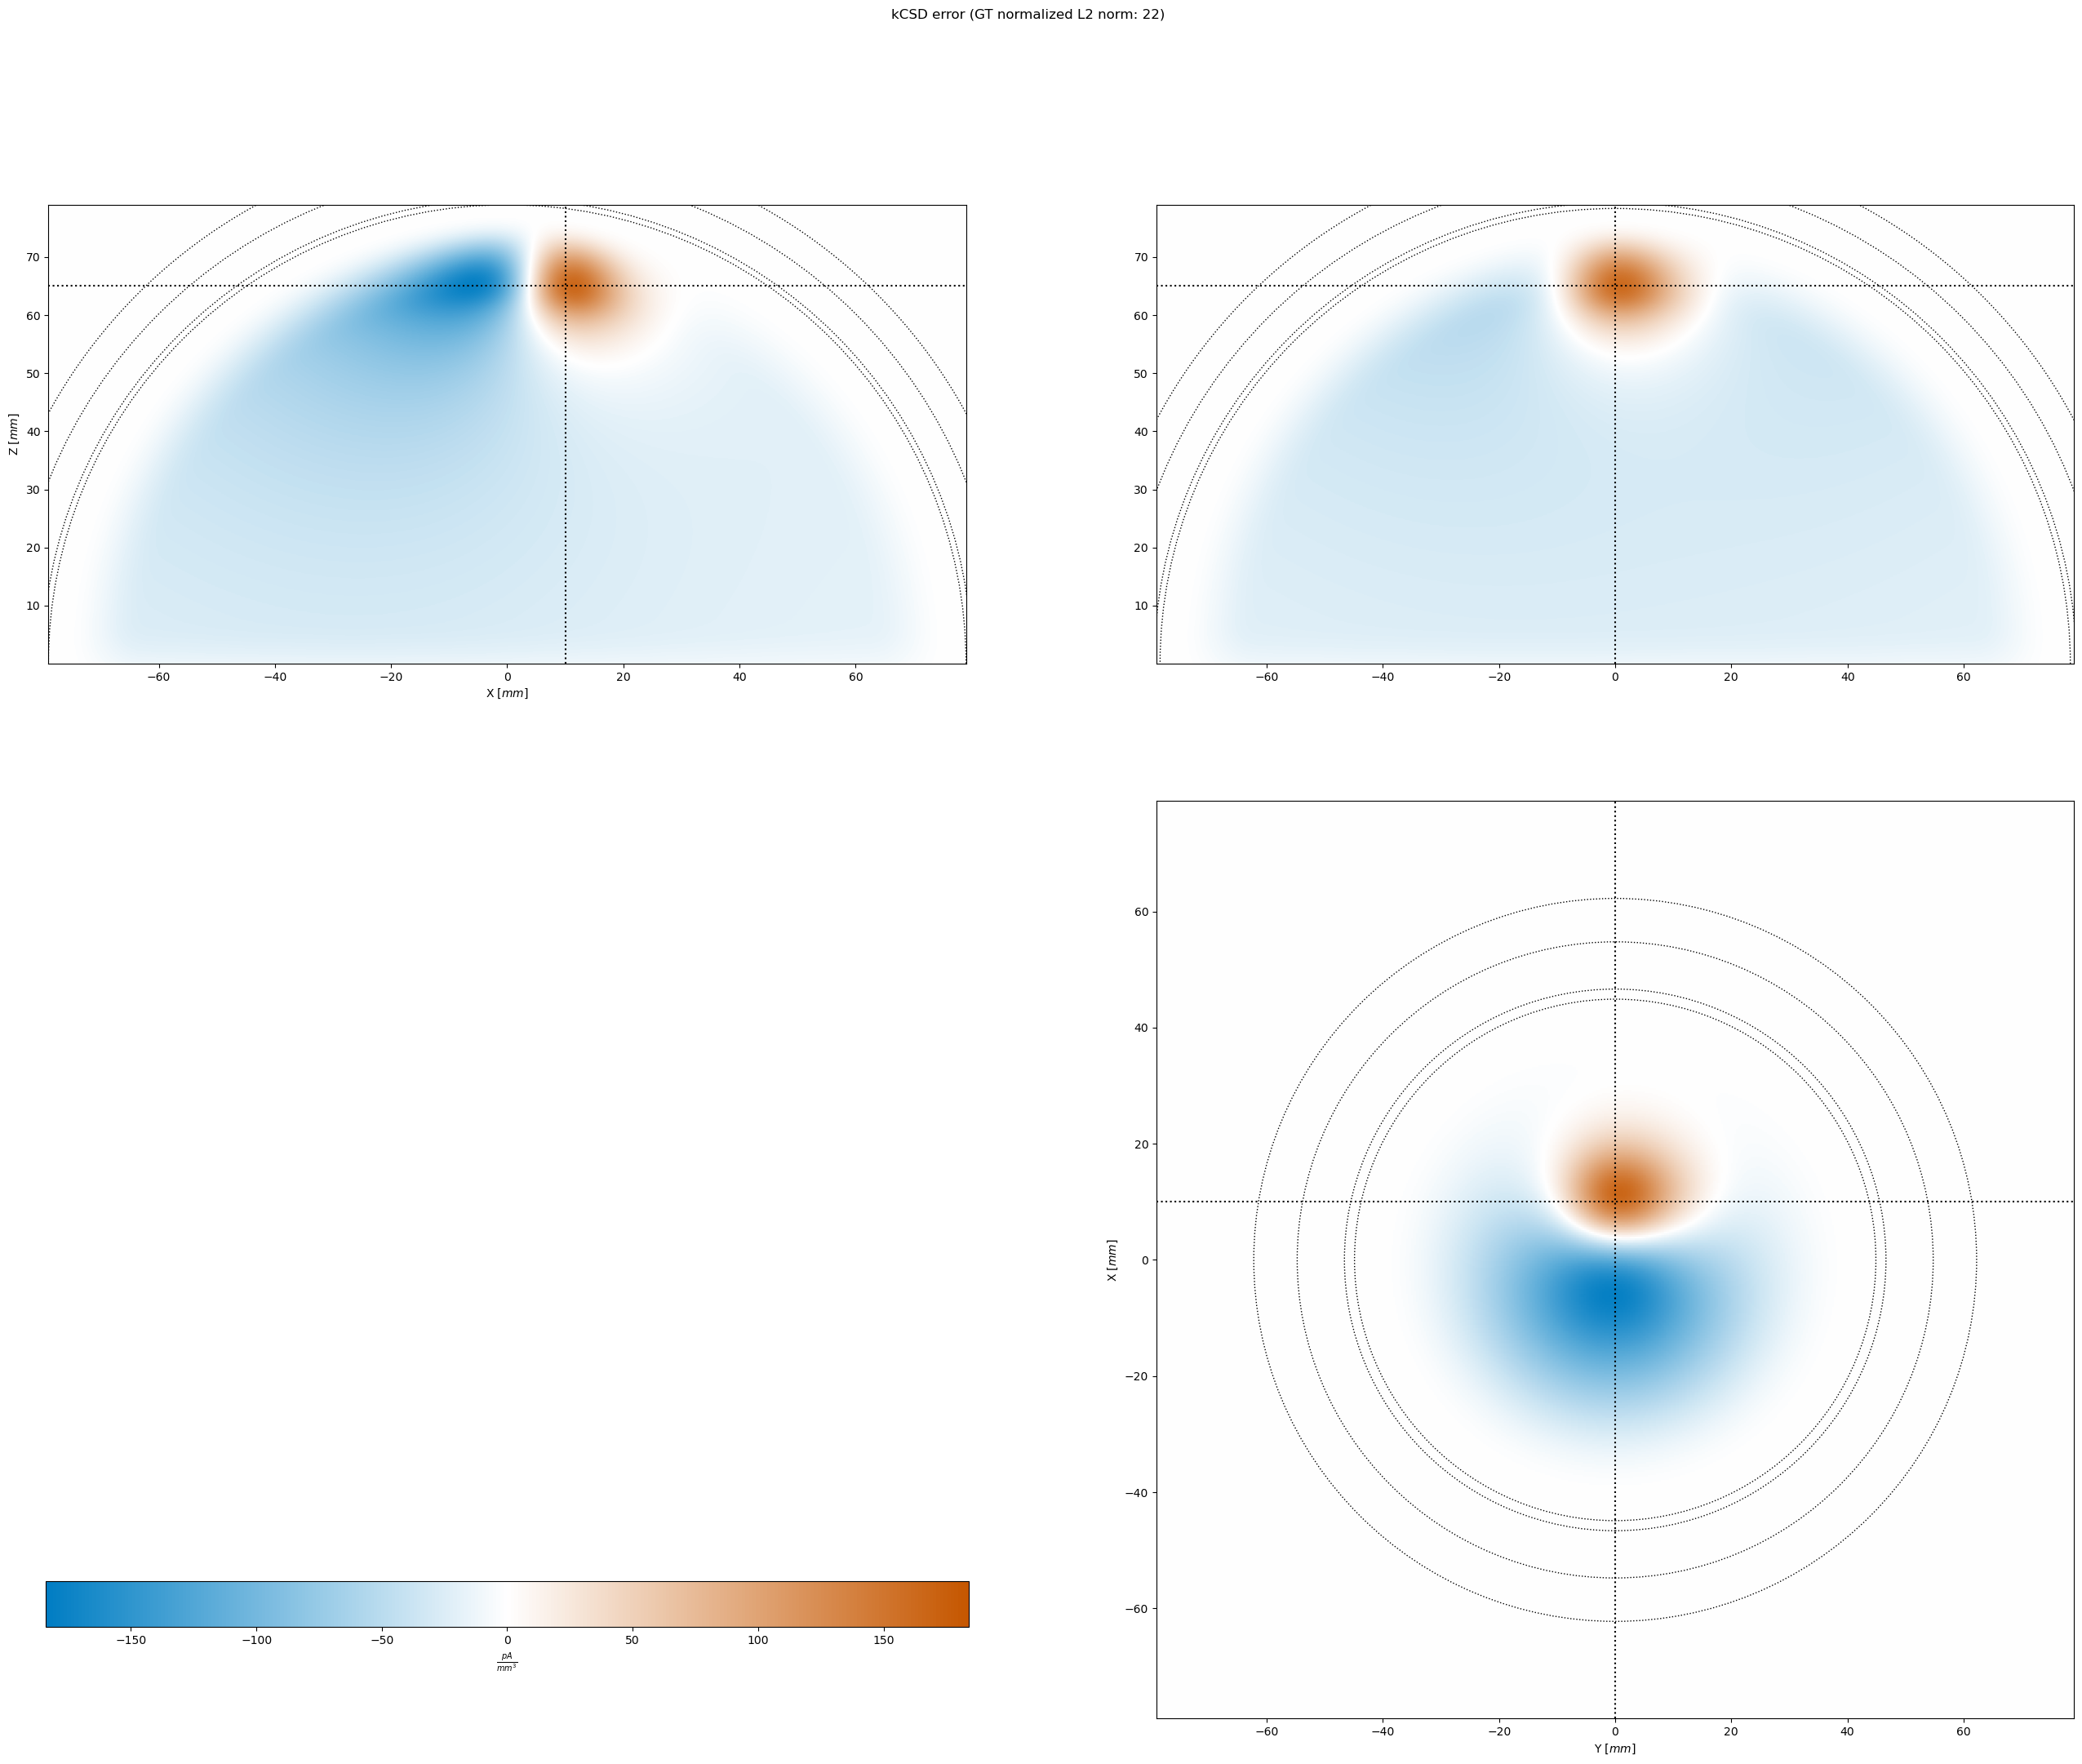

In [37]:
csd_plotter.compare_with_gt(GT_CSD,
                            CSD_KCSD,
                            'kCSD')

The reconstruction is mostly error.

In [38]:
del CSD_KCSD  # the array is large and no longer needed

In [39]:
del reconstructor_kcsd, CROSSKERNEL_KCSD  # these objects are large and no longer needed

## kESI

In [40]:
%%time
B_KESI = kernel_constructor.potential_basis_functions_at_electrodes(electrodes,
                                                                    pbf_kesi)

CPU times: user 34.5 s, sys: 15.1 s, total: 49.6 s
Wall time: 49.6 s


It may take more than a minute.

In [41]:
KERNEL_KESI = kernel_constructor.kernel(B_KESI)

In [42]:
%%time
CROSSKERNEL_KESI = kernel_constructor.crosskernel(B_KESI)

CPU times: user 8.84 s, sys: 4.28 s, total: 13.1 s
Wall time: 13.1 s


In [43]:
del B_KESI  # the array is large and no longer needed

In [44]:
reconstructor_kesi = Reconstructor(KERNEL_KESI,
                                   CROSSKERNEL_KESI)

In [45]:
CSD_KESI = to_3D(reconstructor_kesi(GT_V))

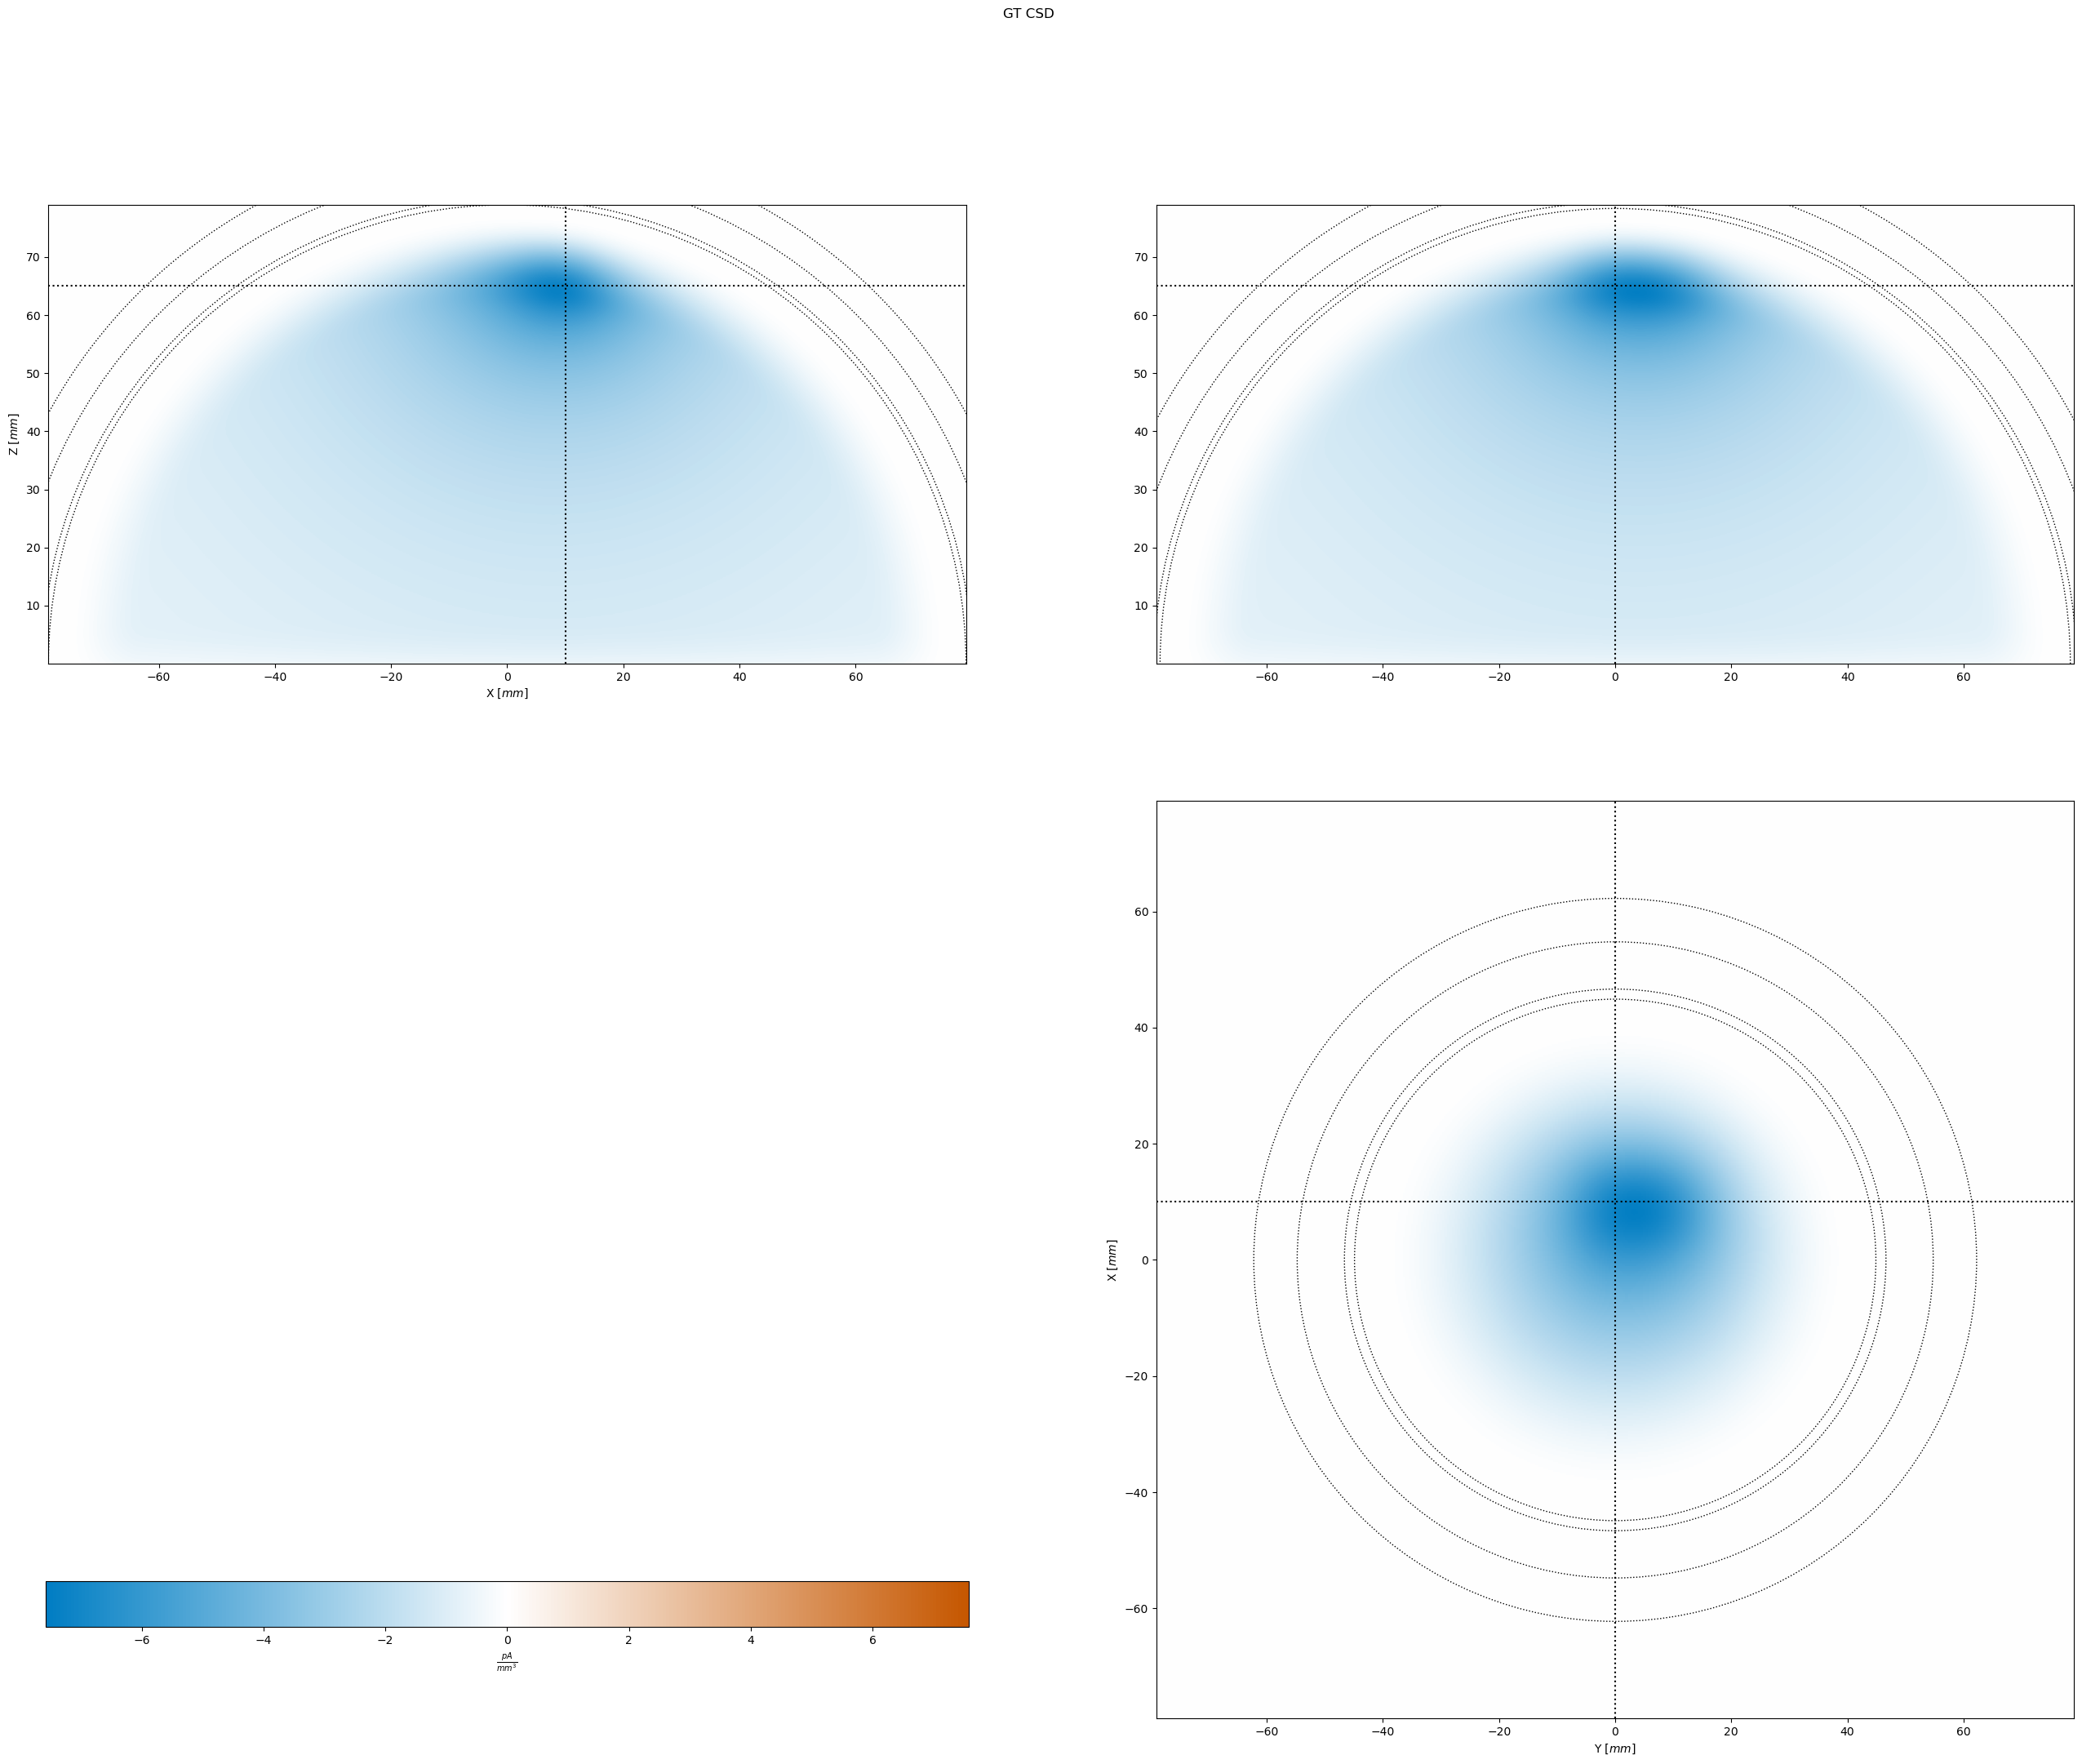

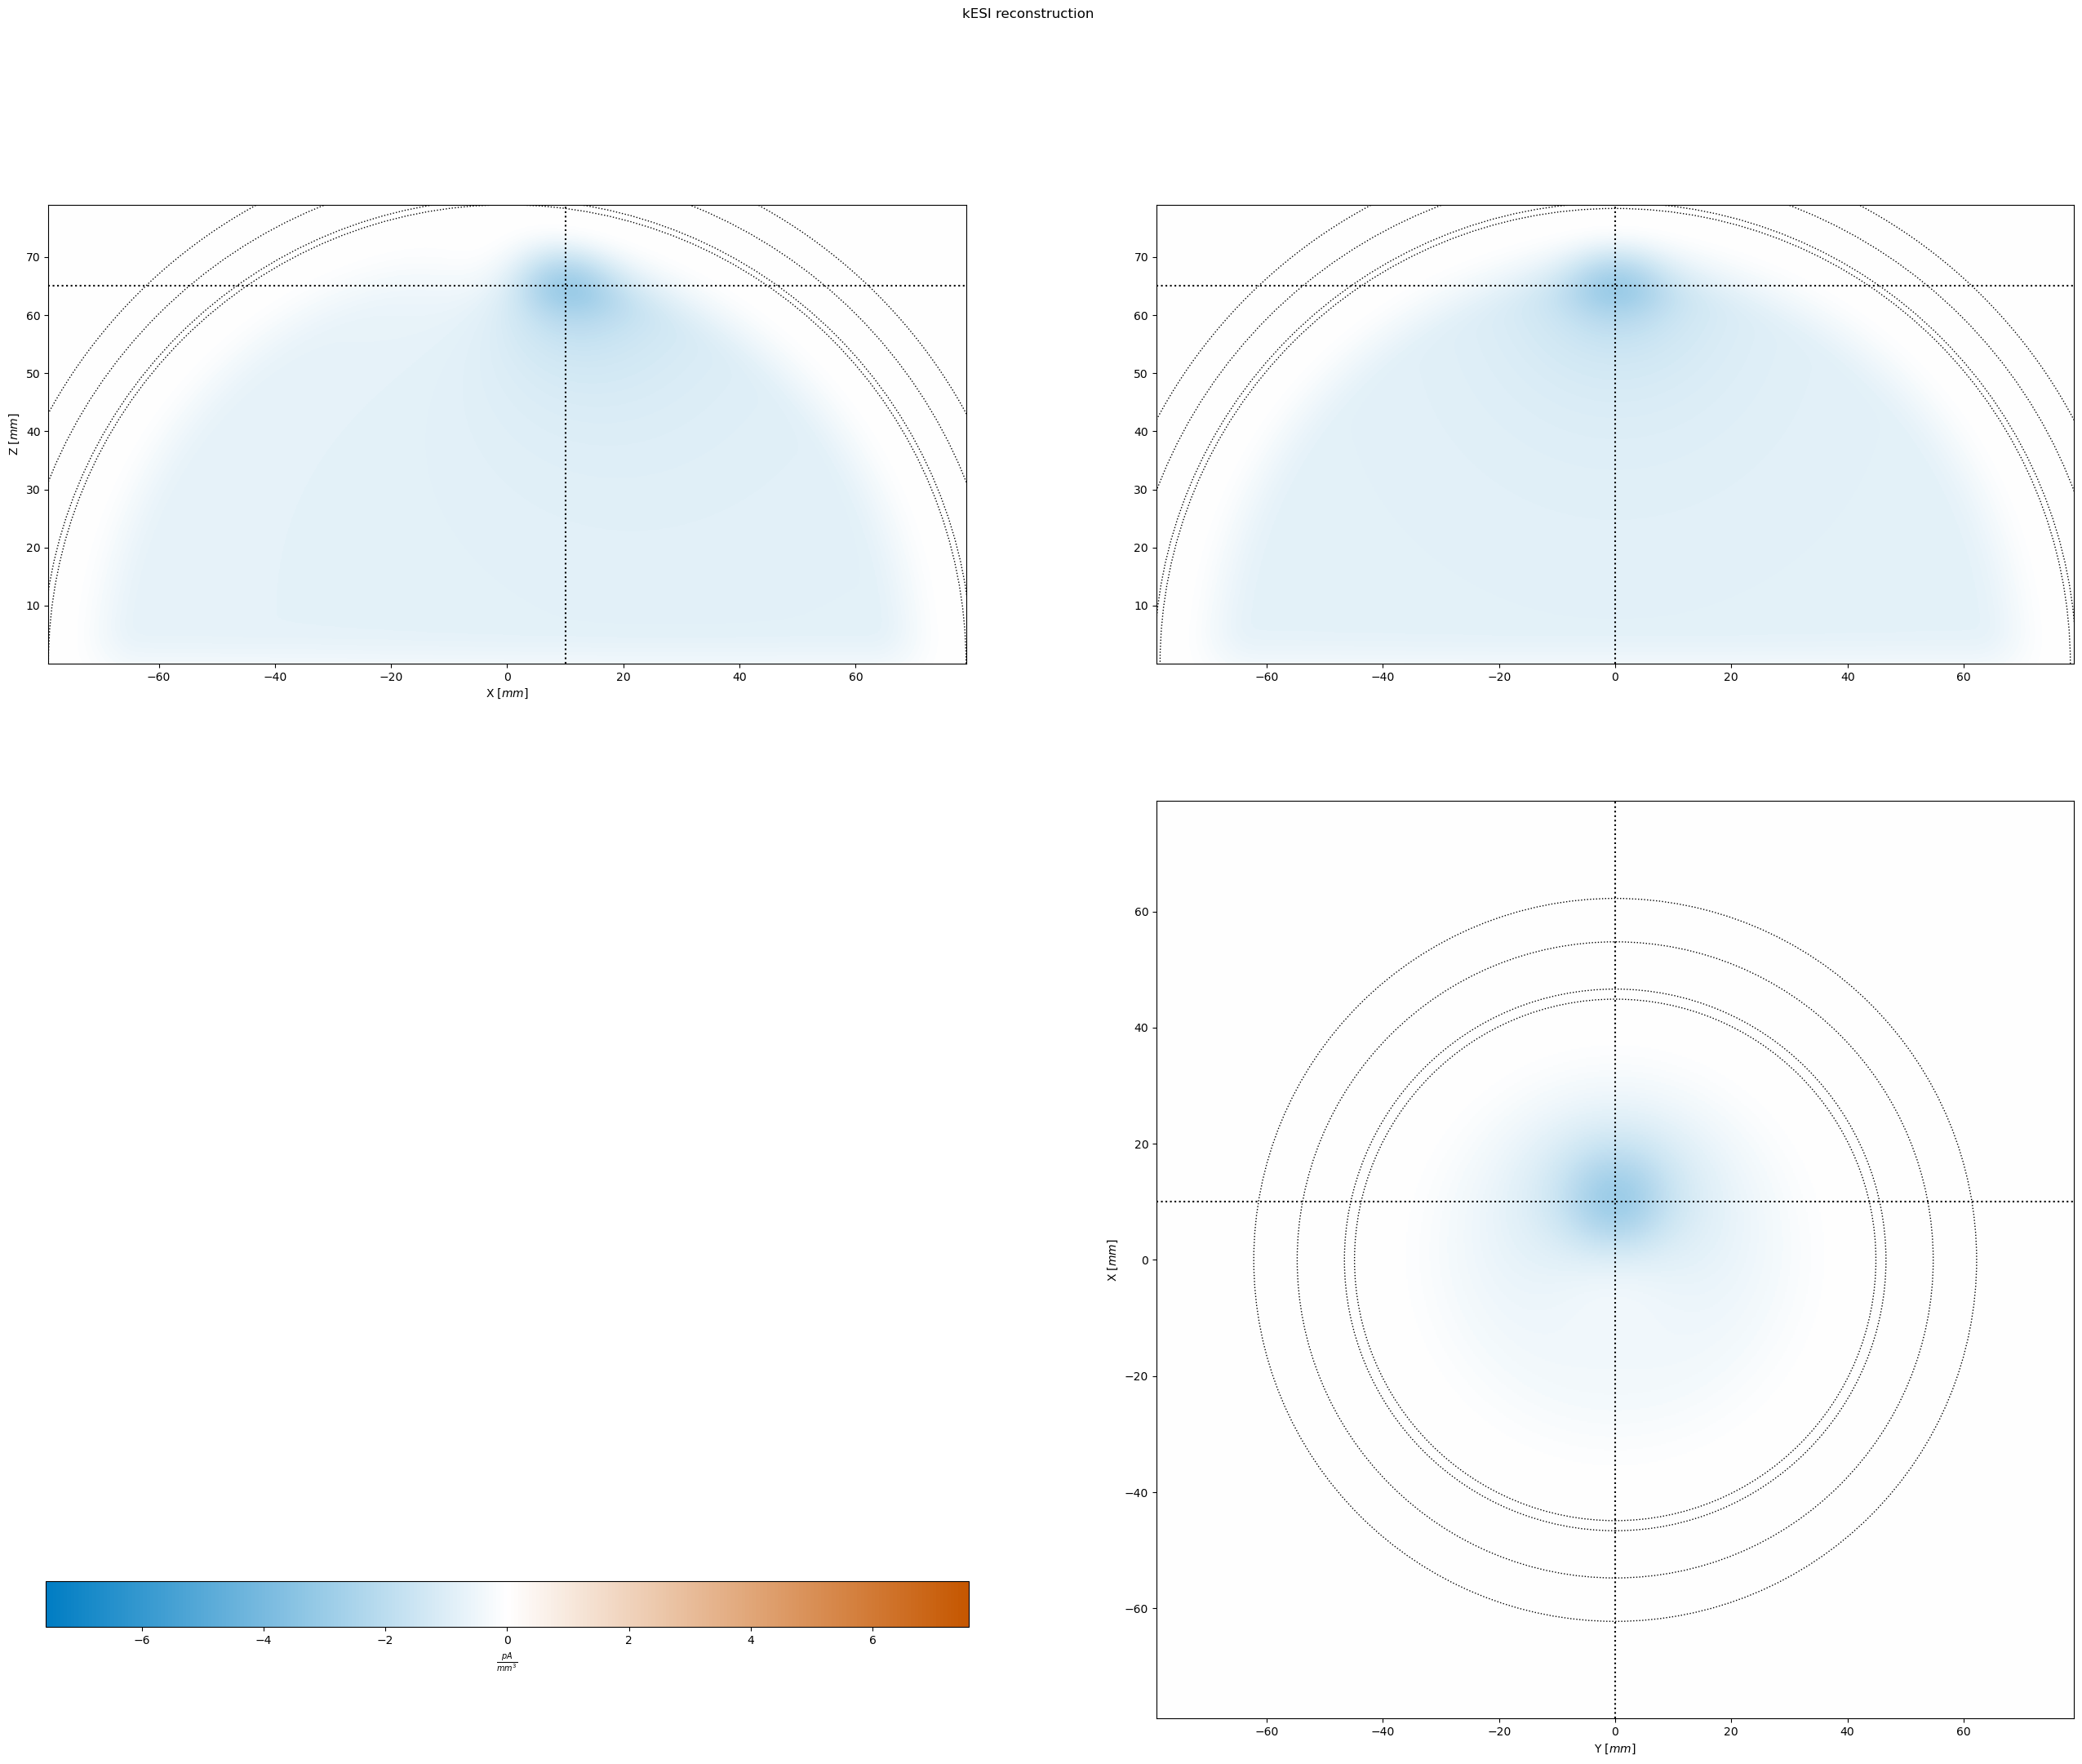

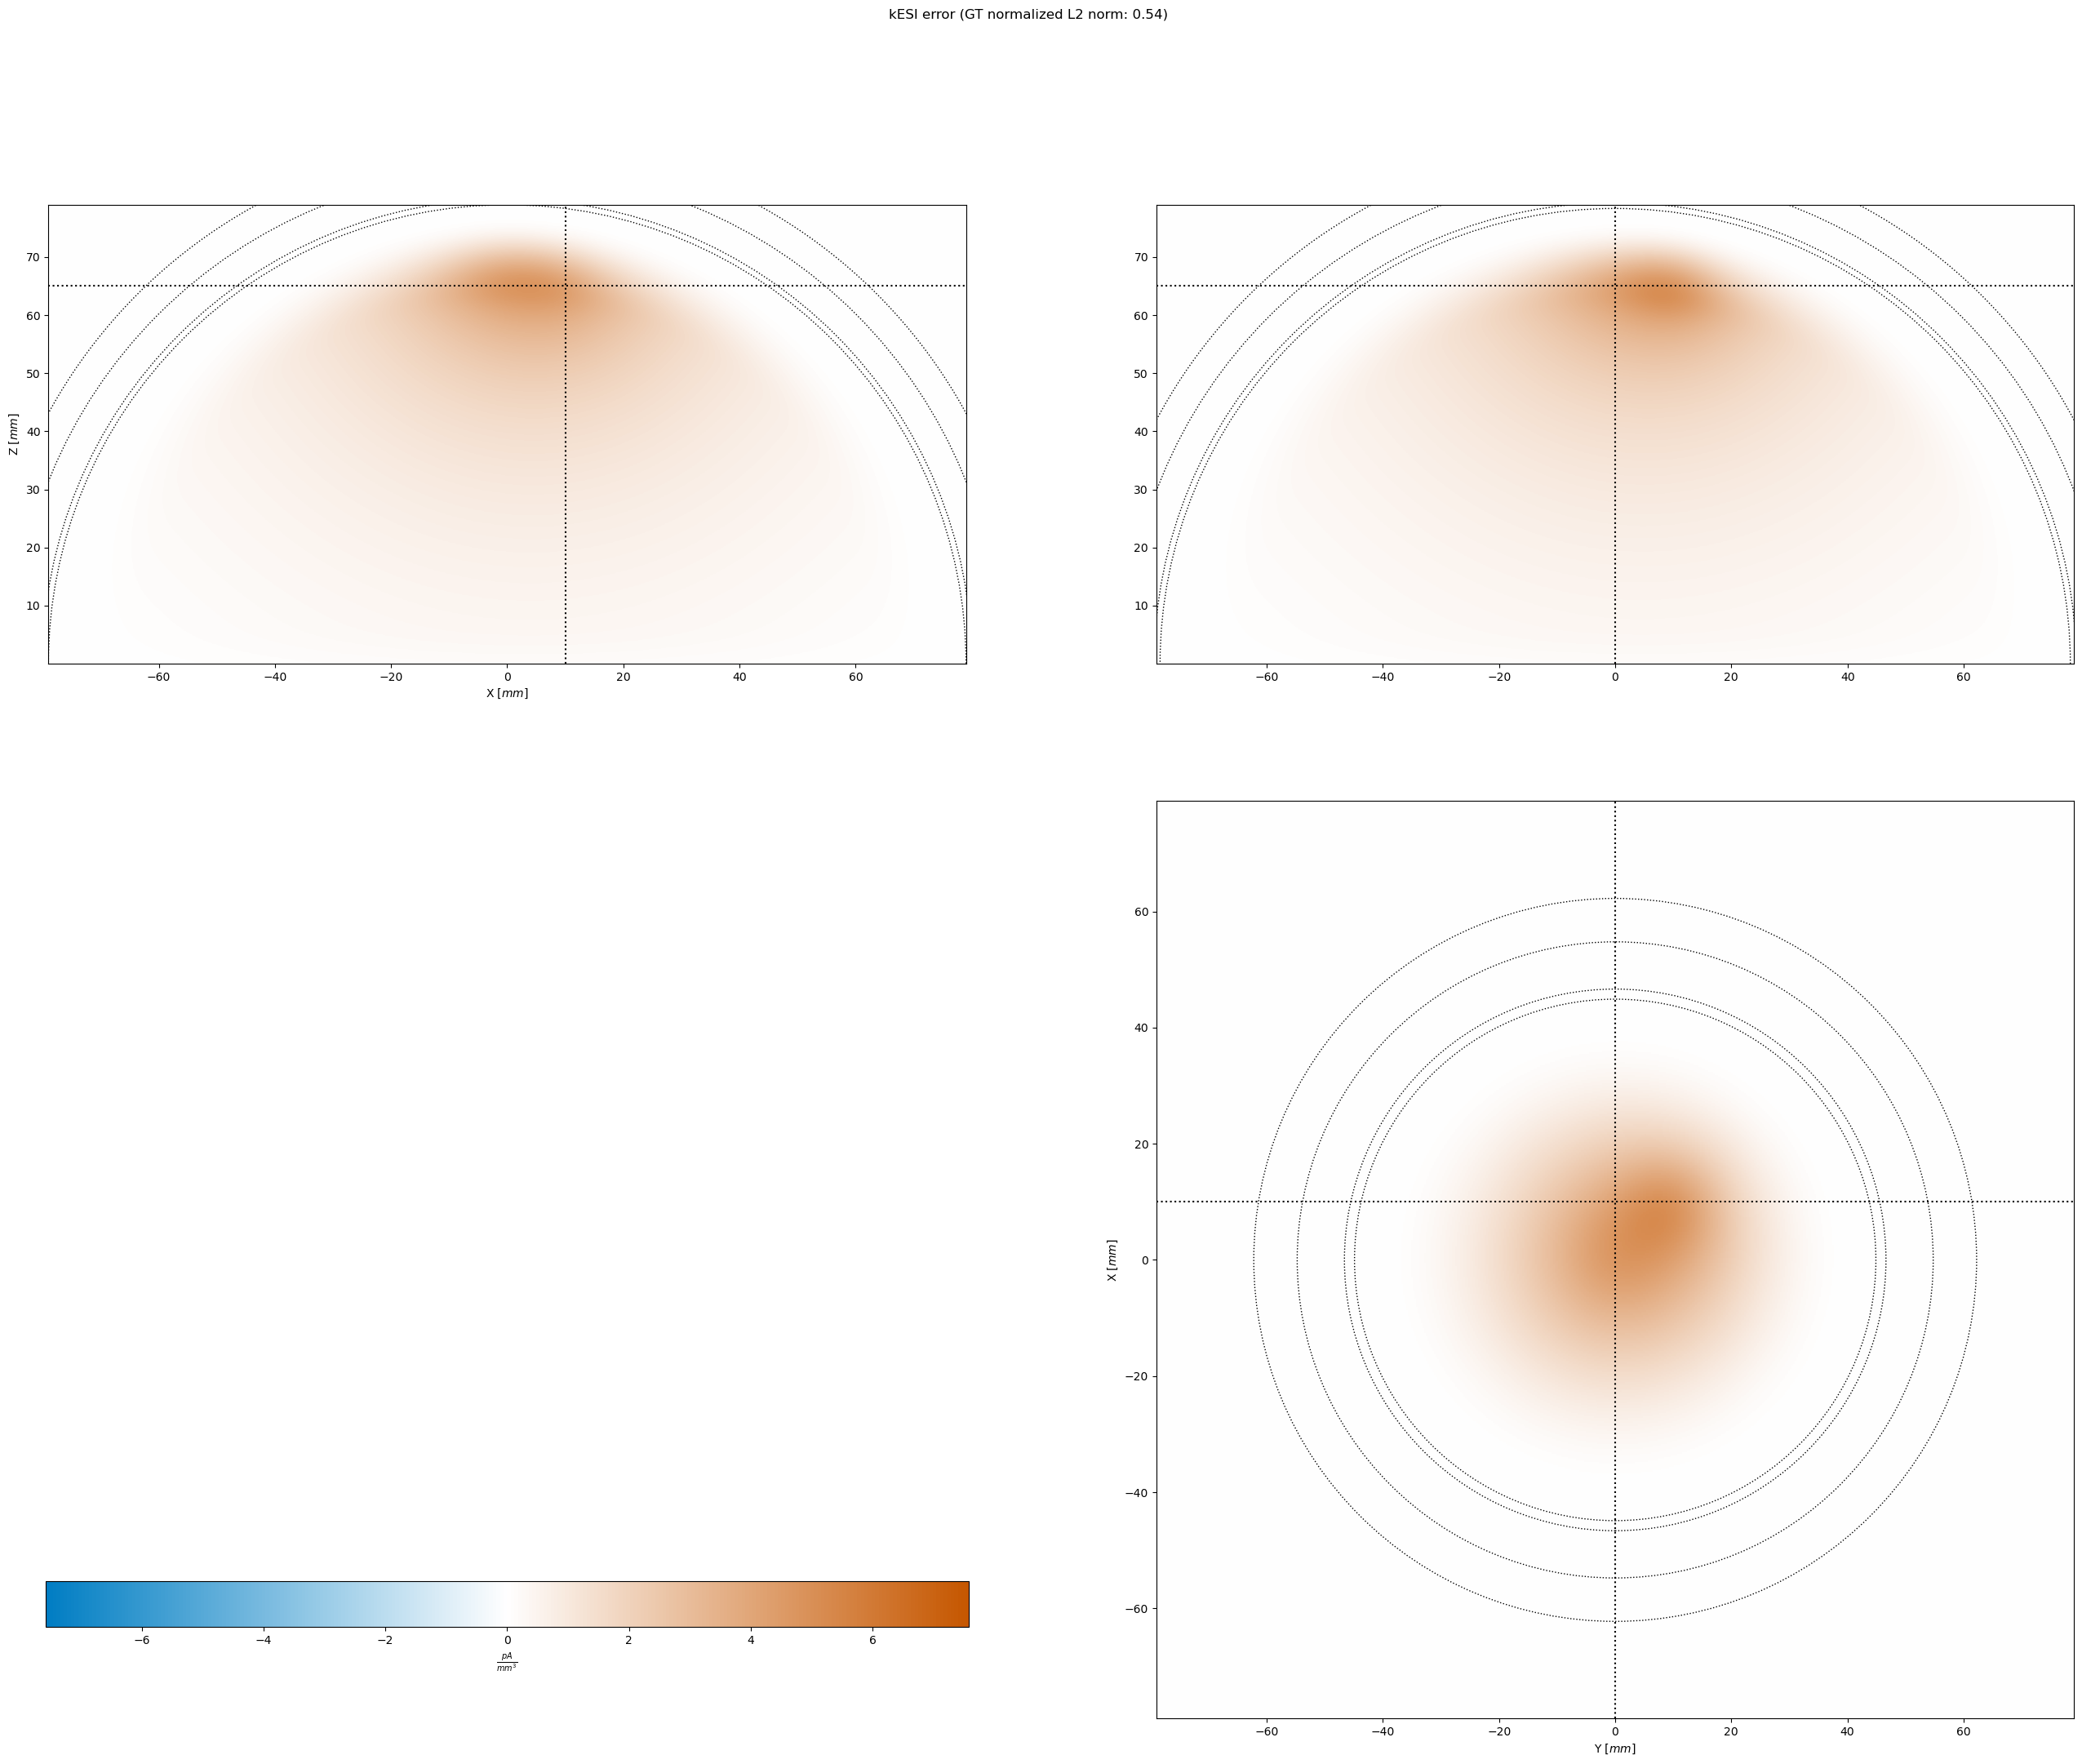

In [46]:
csd_plotter.compare_with_gt(GT_CSD,
                            CSD_KESI,
                            'kESI')

The reconstruction is much closer to the ground truth.
Note that kESI may be at a disadvantage, as the ground
truth CSD is an eigensource of kCSD.

In [47]:
del CSD_KESI  # the array is large and no longer needed

## Noise

As no real-world measurement is perfect, we introduce
2% noise to test how kESI deals with it.

In [48]:
np.random.seed(42)

V_WITH_NOISE = np.random.normal(loc=GT_V,
                                scale=0.02*np.sqrt(np.square(GT_V).mean()))

In [49]:
CSD_KESI_WITH_NOISE = to_3D(reconstructor_kesi(V_WITH_NOISE))

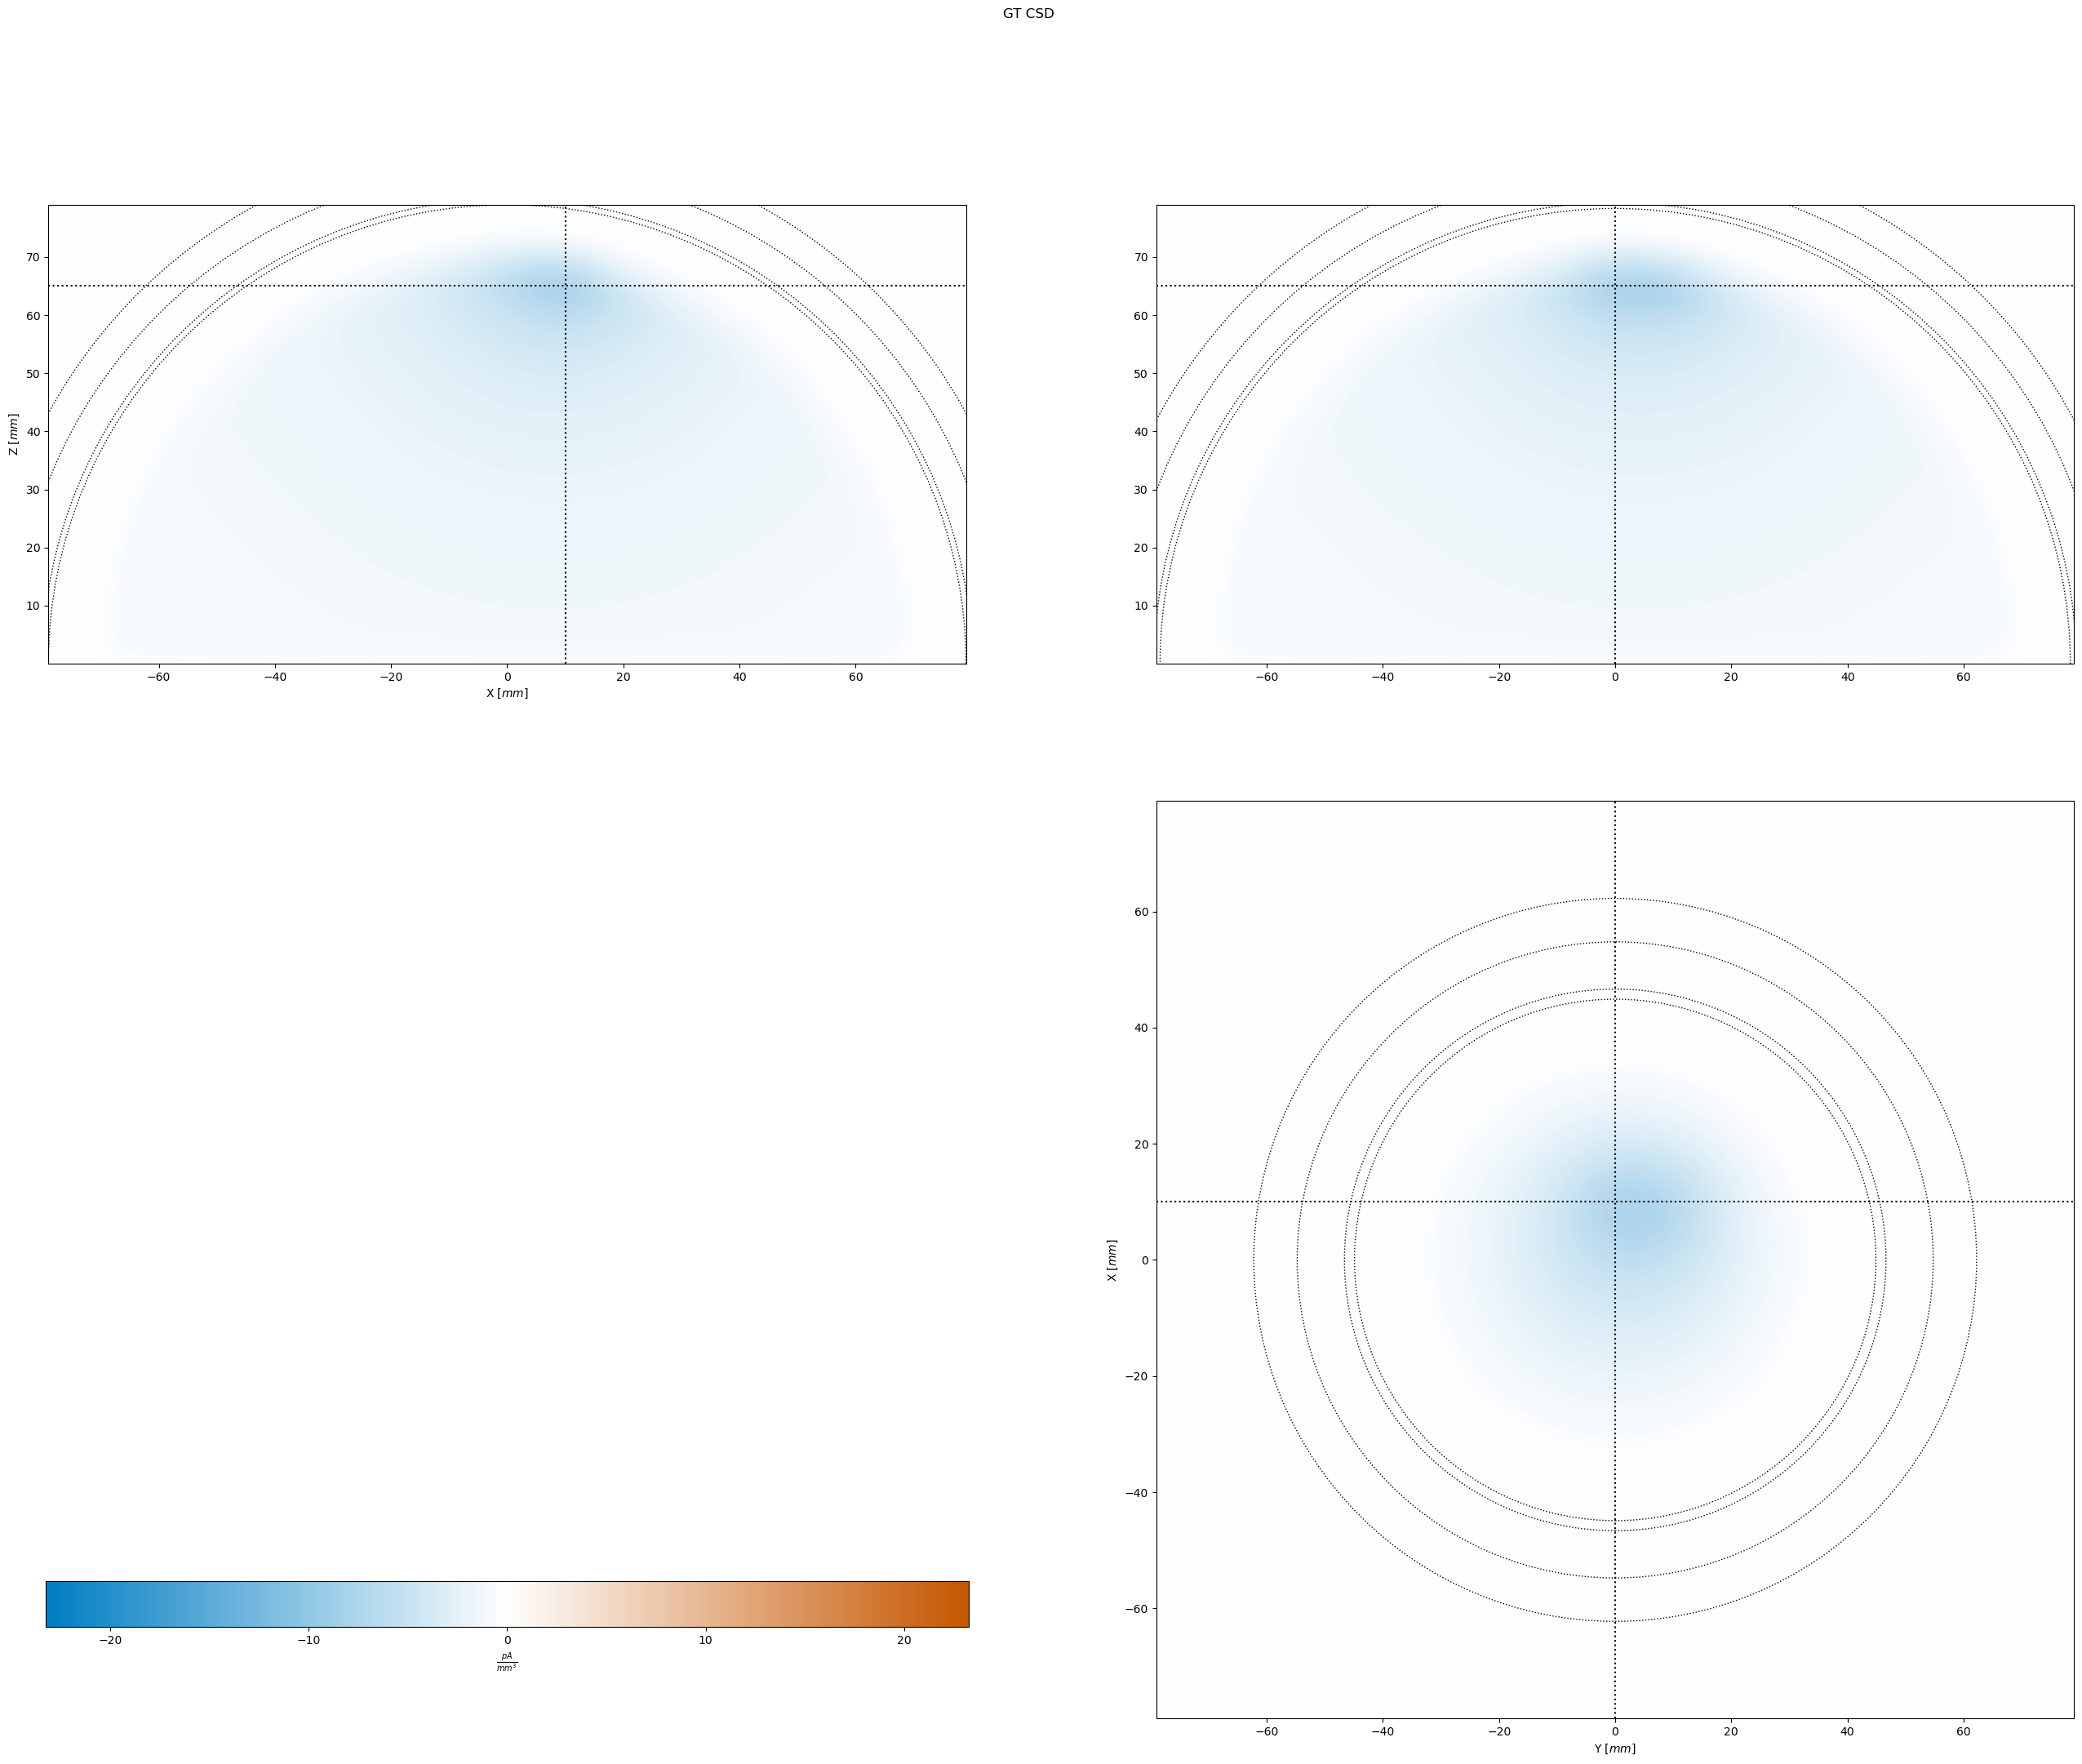

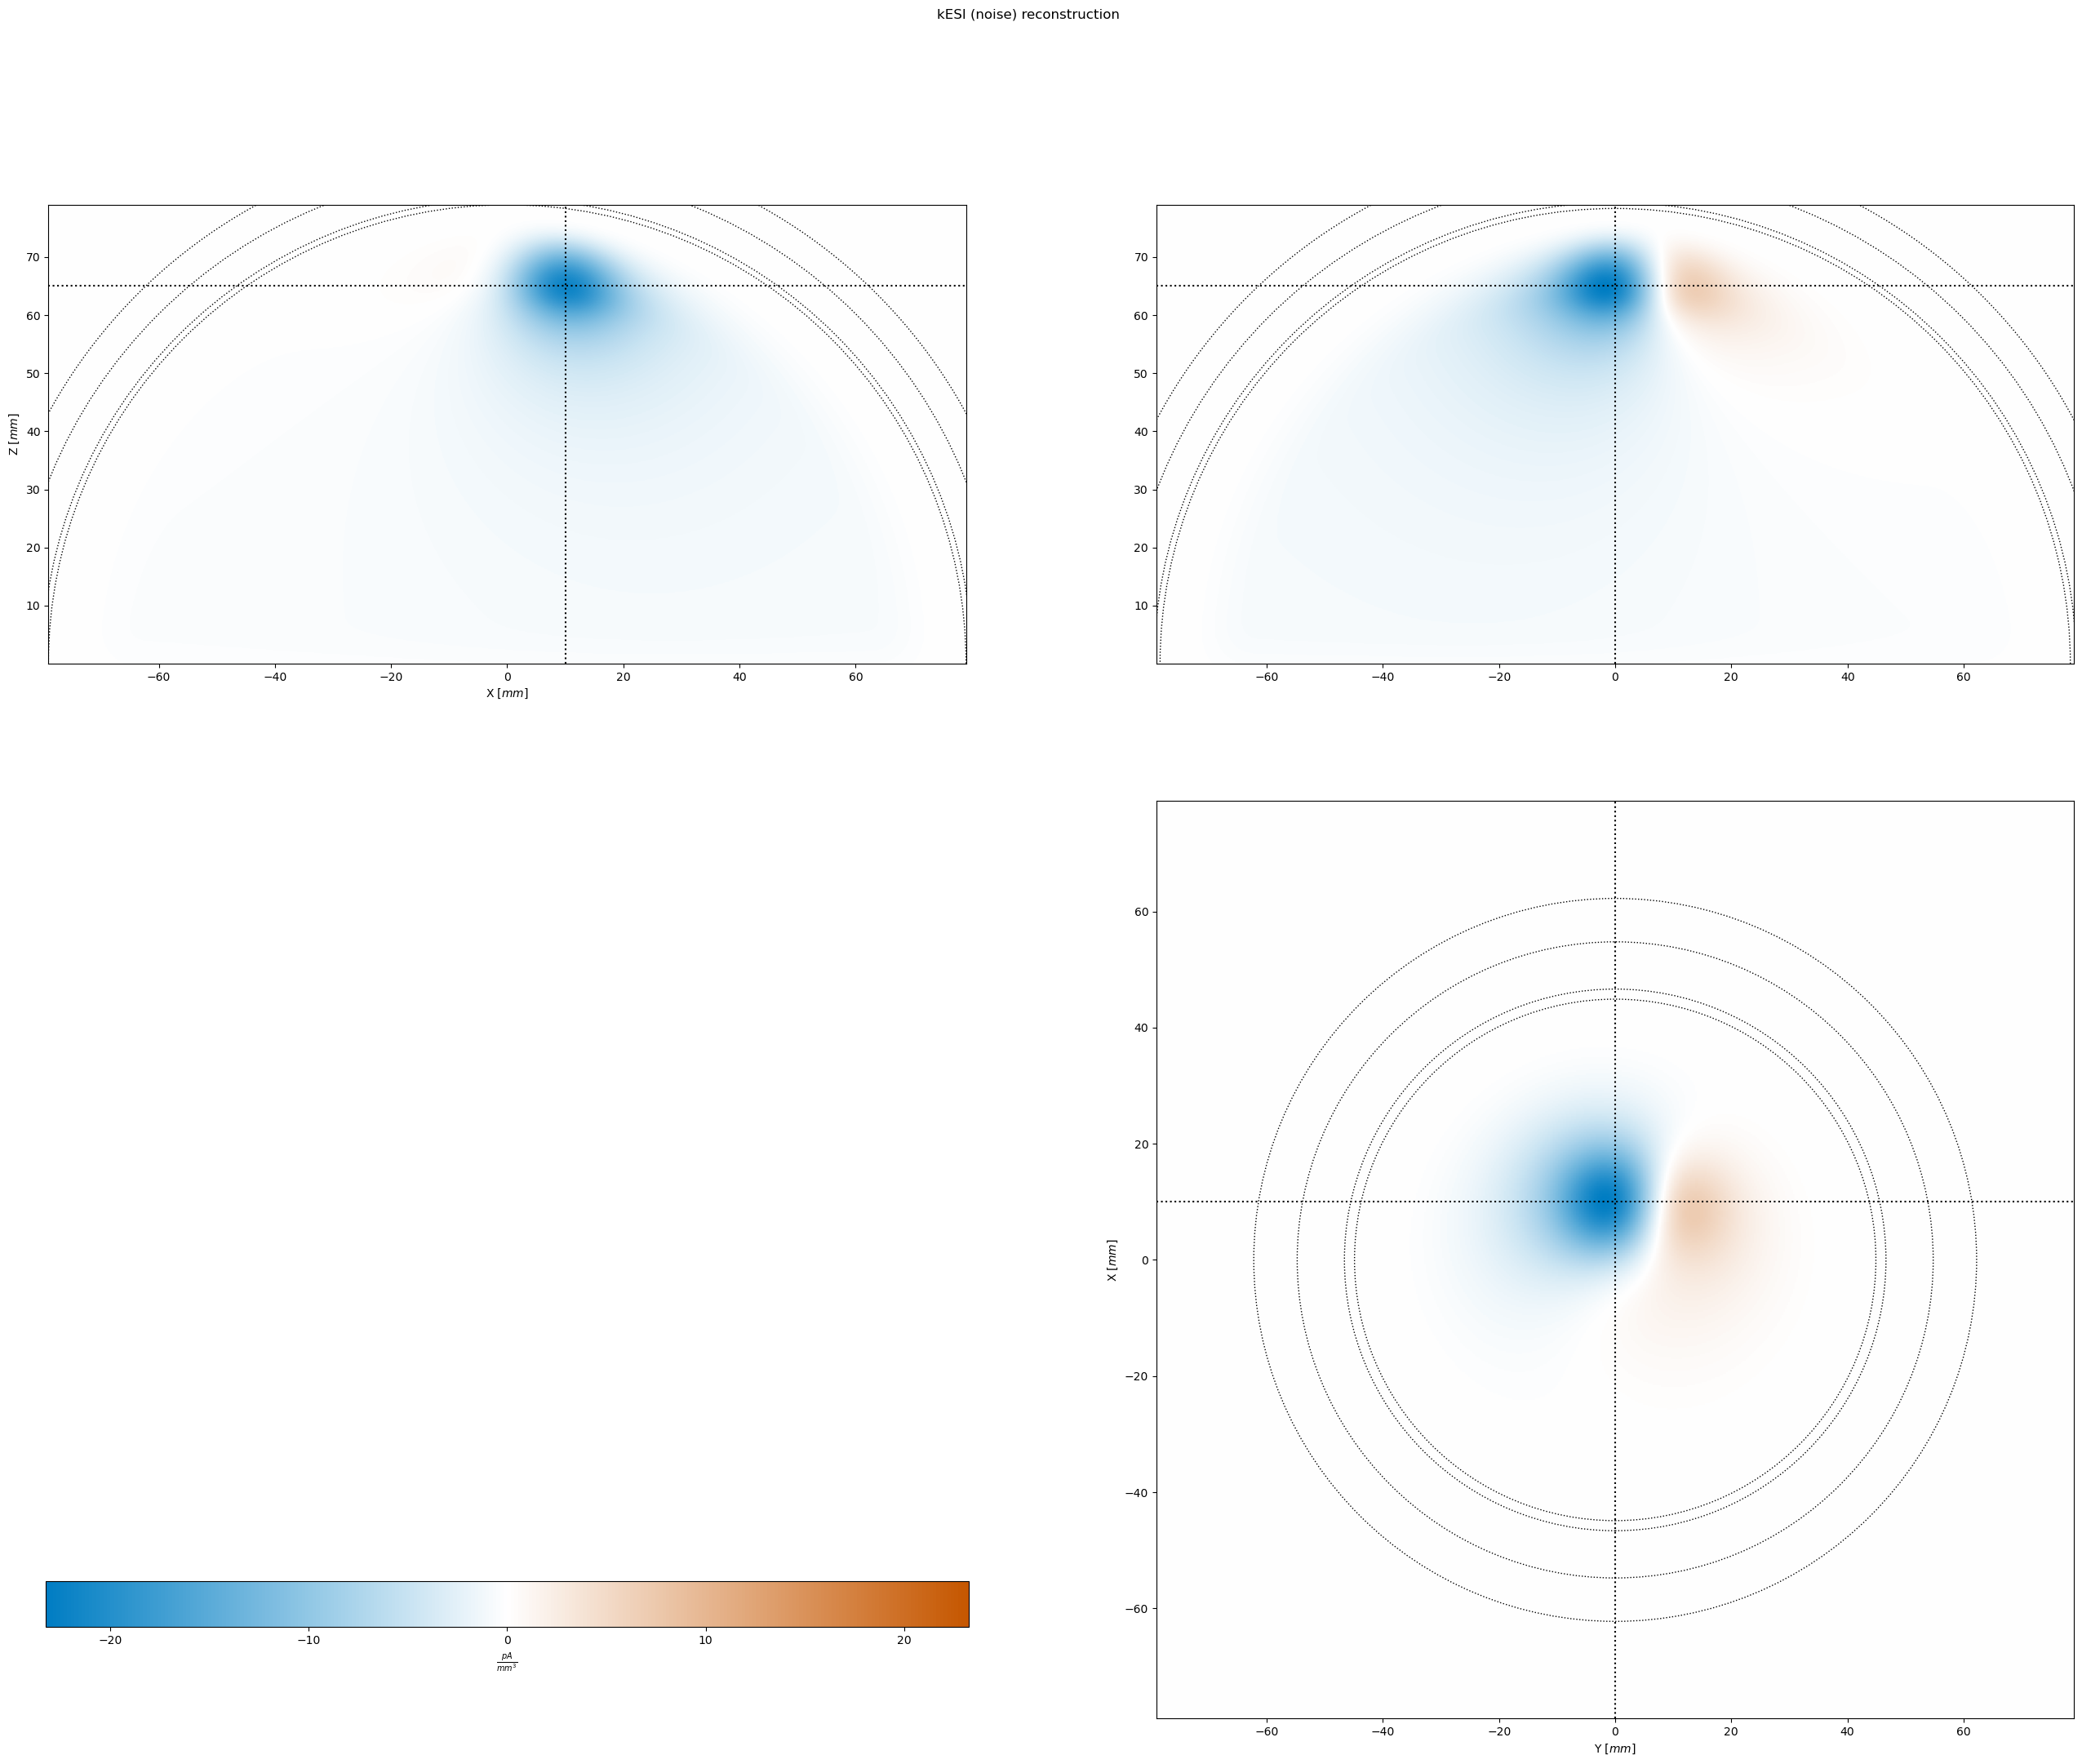

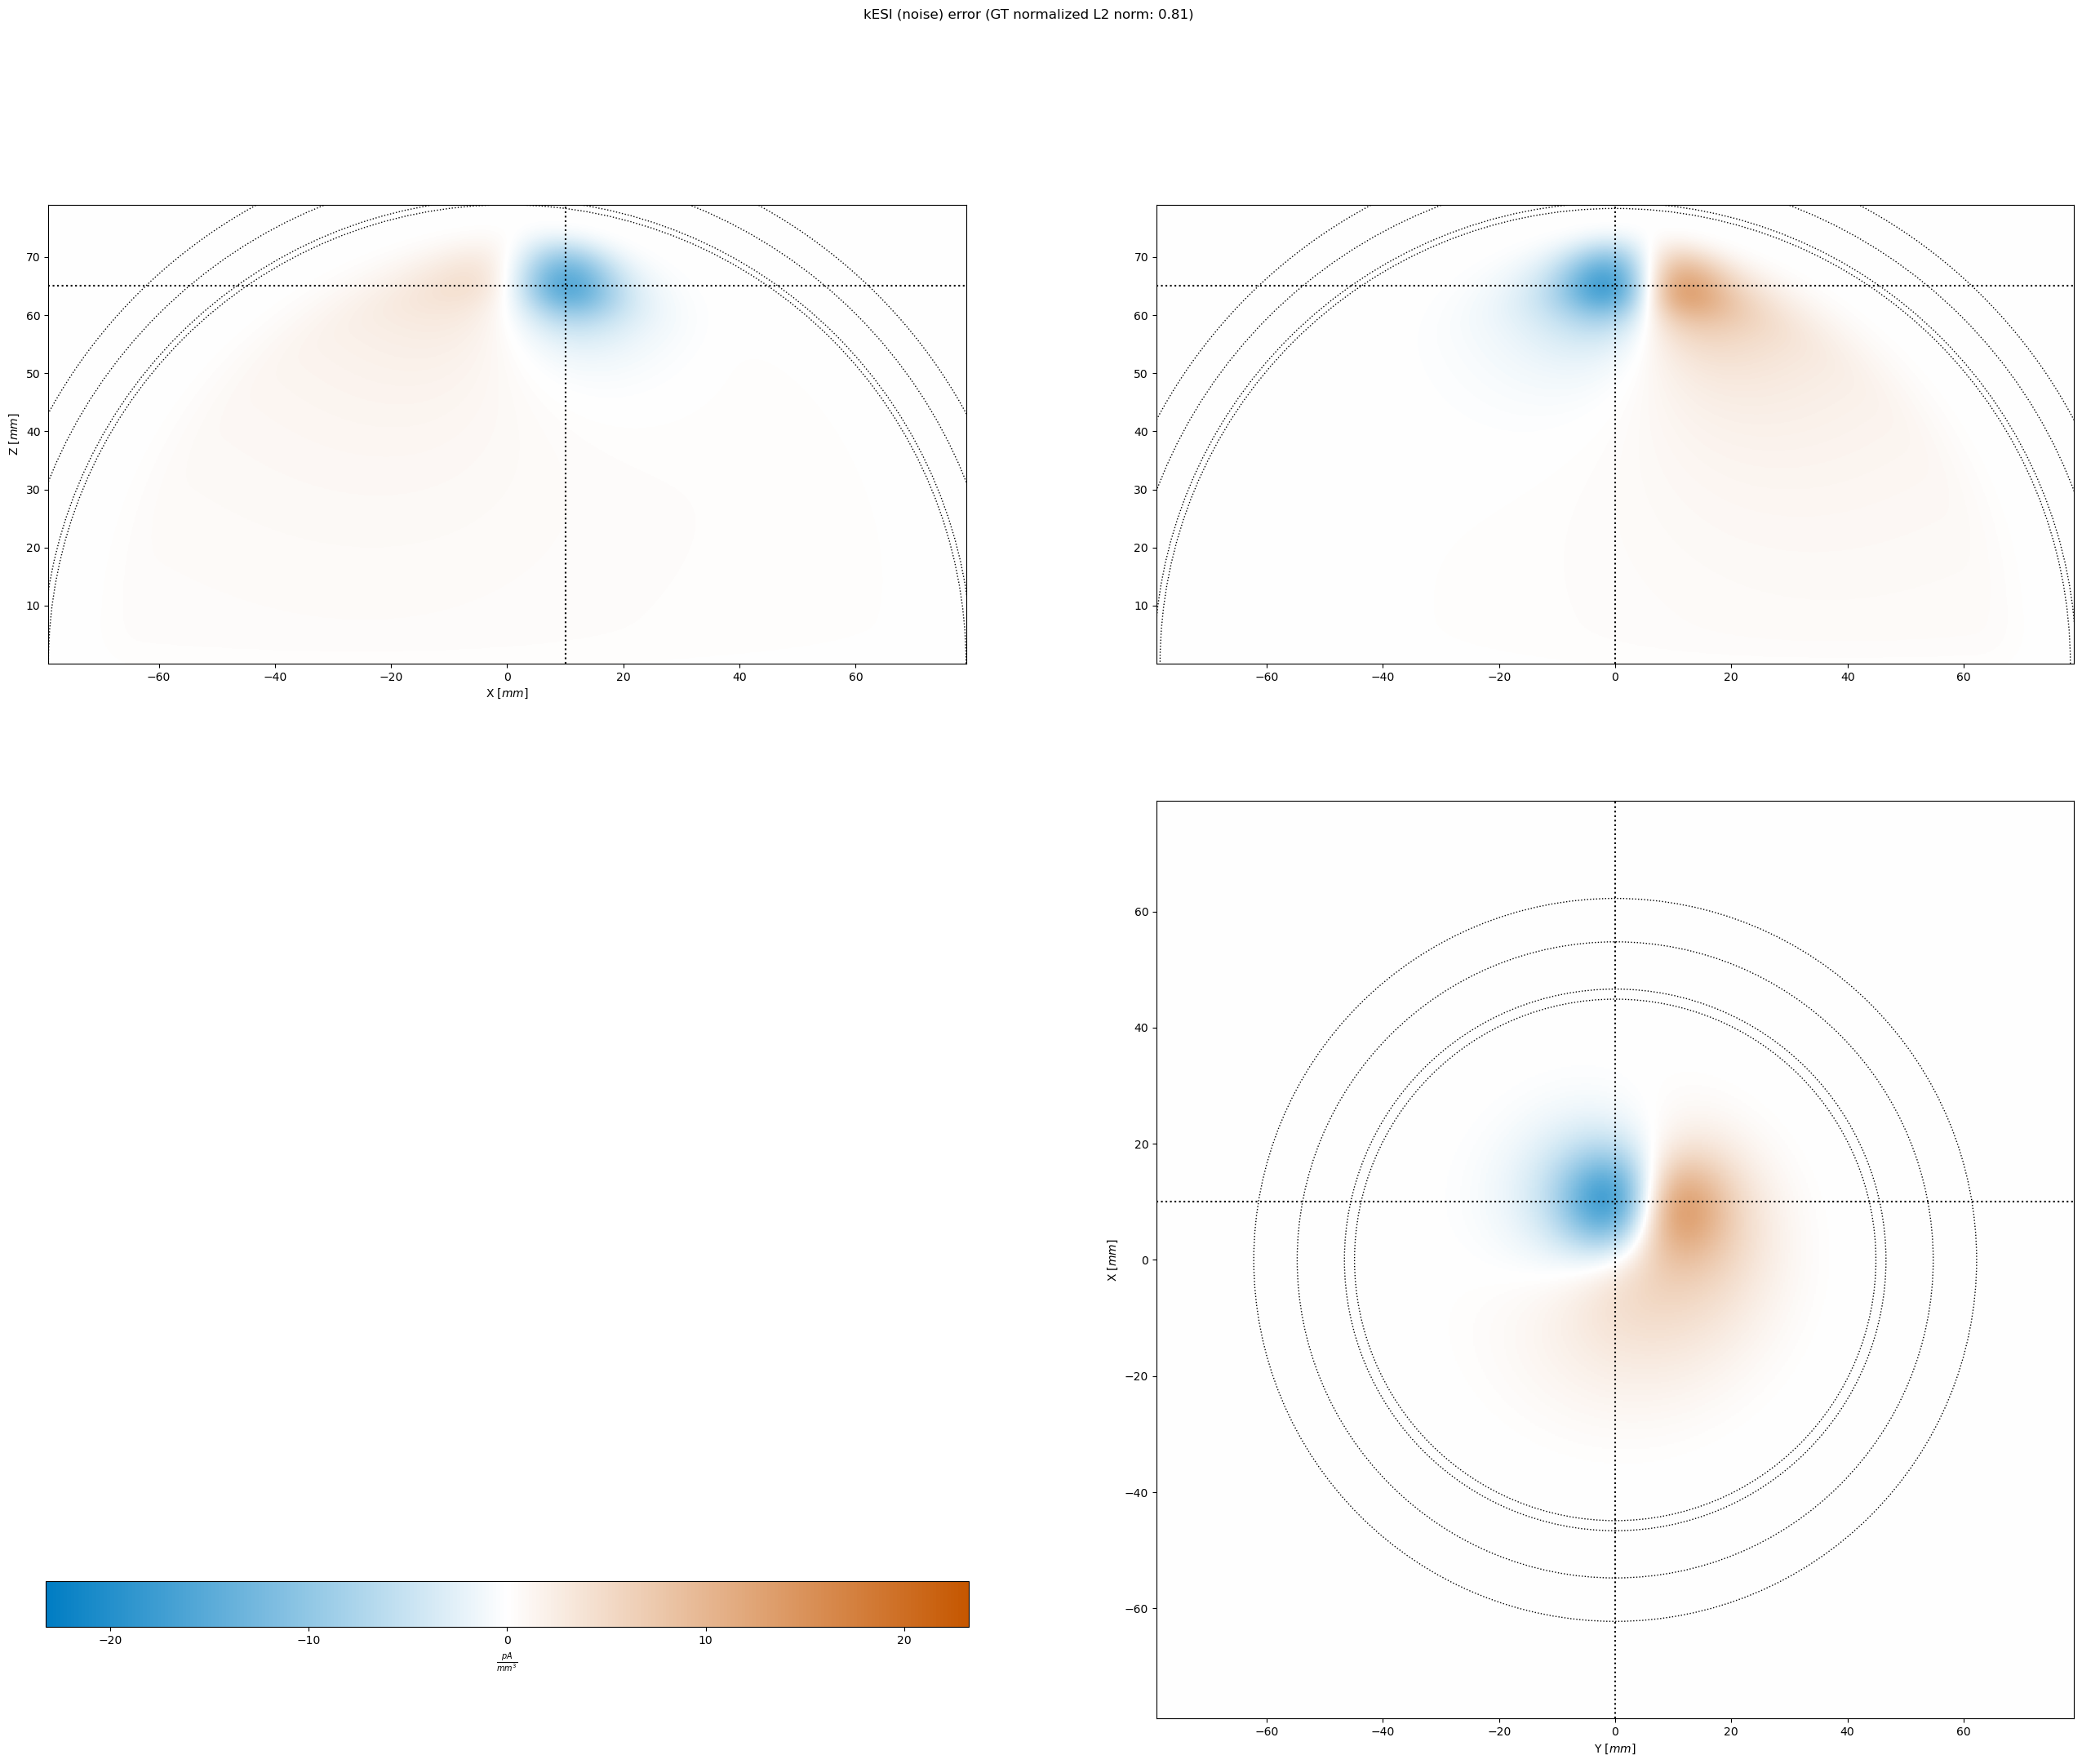

In [50]:
csd_plotter.compare_with_gt(GT_CSD,
                            CSD_KESI_WITH_NOISE,
                            'kESI (noise)')

In [51]:
del CSD_KESI_WITH_NOISE  # the array is large and no longer needed

The quality of reconstruction decreased significatntly.

## Regularization

In [52]:
EIGENVALUES_KESI, _ = eigh(KERNEL_KESI)

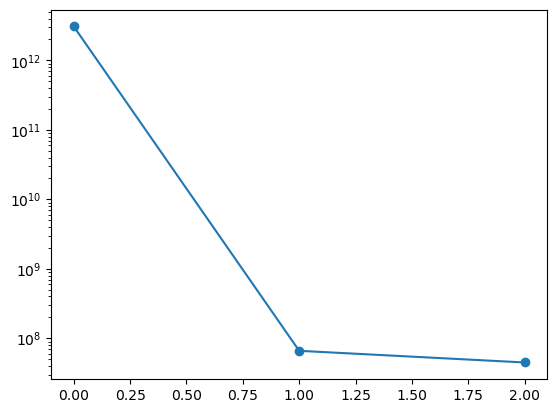

In [53]:
plt.plot(EIGENVALUES_KESI,
         marker='o')

plt.yscale('log')

In [54]:
REGULARIZATION_PARAMETERS = np.logspace(5, 13, 8 * 10 + 1)

assert REGULARIZATION_PARAMETERS.min() <= EIGENVALUES_KESI.min()
assert EIGENVALUES_KESI.max() <= REGULARIZATION_PARAMETERS.max()

### Leave-one-out cross-validation

In [55]:
from kesi.common import cv

In [56]:
%%time
CV_ERRORS = cv(reconstructor_kesi, V_WITH_NOISE, REGULARIZATION_PARAMETERS)

CPU times: user 8.03 ms, sys: 0 ns, total: 8.03 ms
Wall time: 6.66 ms


In [57]:
regularization_parameter_idx = np.argmin(CV_ERRORS)
regularization_parameter = REGULARIZATION_PARAMETERS[regularization_parameter_idx]

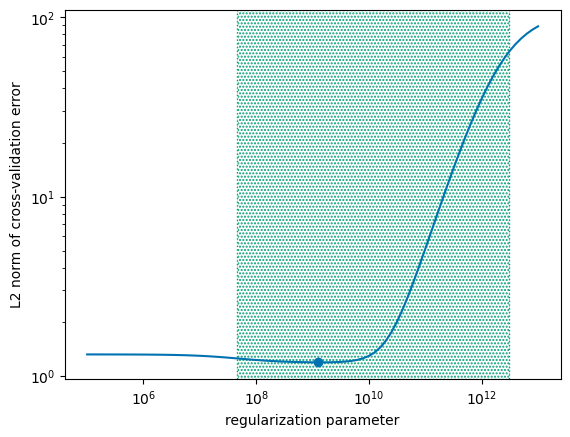

In [58]:
plt.plot(REGULARIZATION_PARAMETERS,
         CV_ERRORS,
         color=cbf.BLUE)
plt.plot(regularization_parameter,
         min(CV_ERRORS),
         marker="o",
         color=cbf.BLUE)
plt.axvspan(EIGENVALUES_KESI.min(),
            EIGENVALUES_KESI.max(),
            ls=":",
            color=cbf.GREEN,
            hatch=".....",
            fill=False)
plt.xlabel('regularization parameter')
plt.xscale('log')
plt.ylabel('L2 norm of cross-validation error')
plt.yscale('log')

In [59]:
CSD_KESI_CV = to_3D(reconstructor_kesi(V_WITH_NOISE, regularization_parameter))

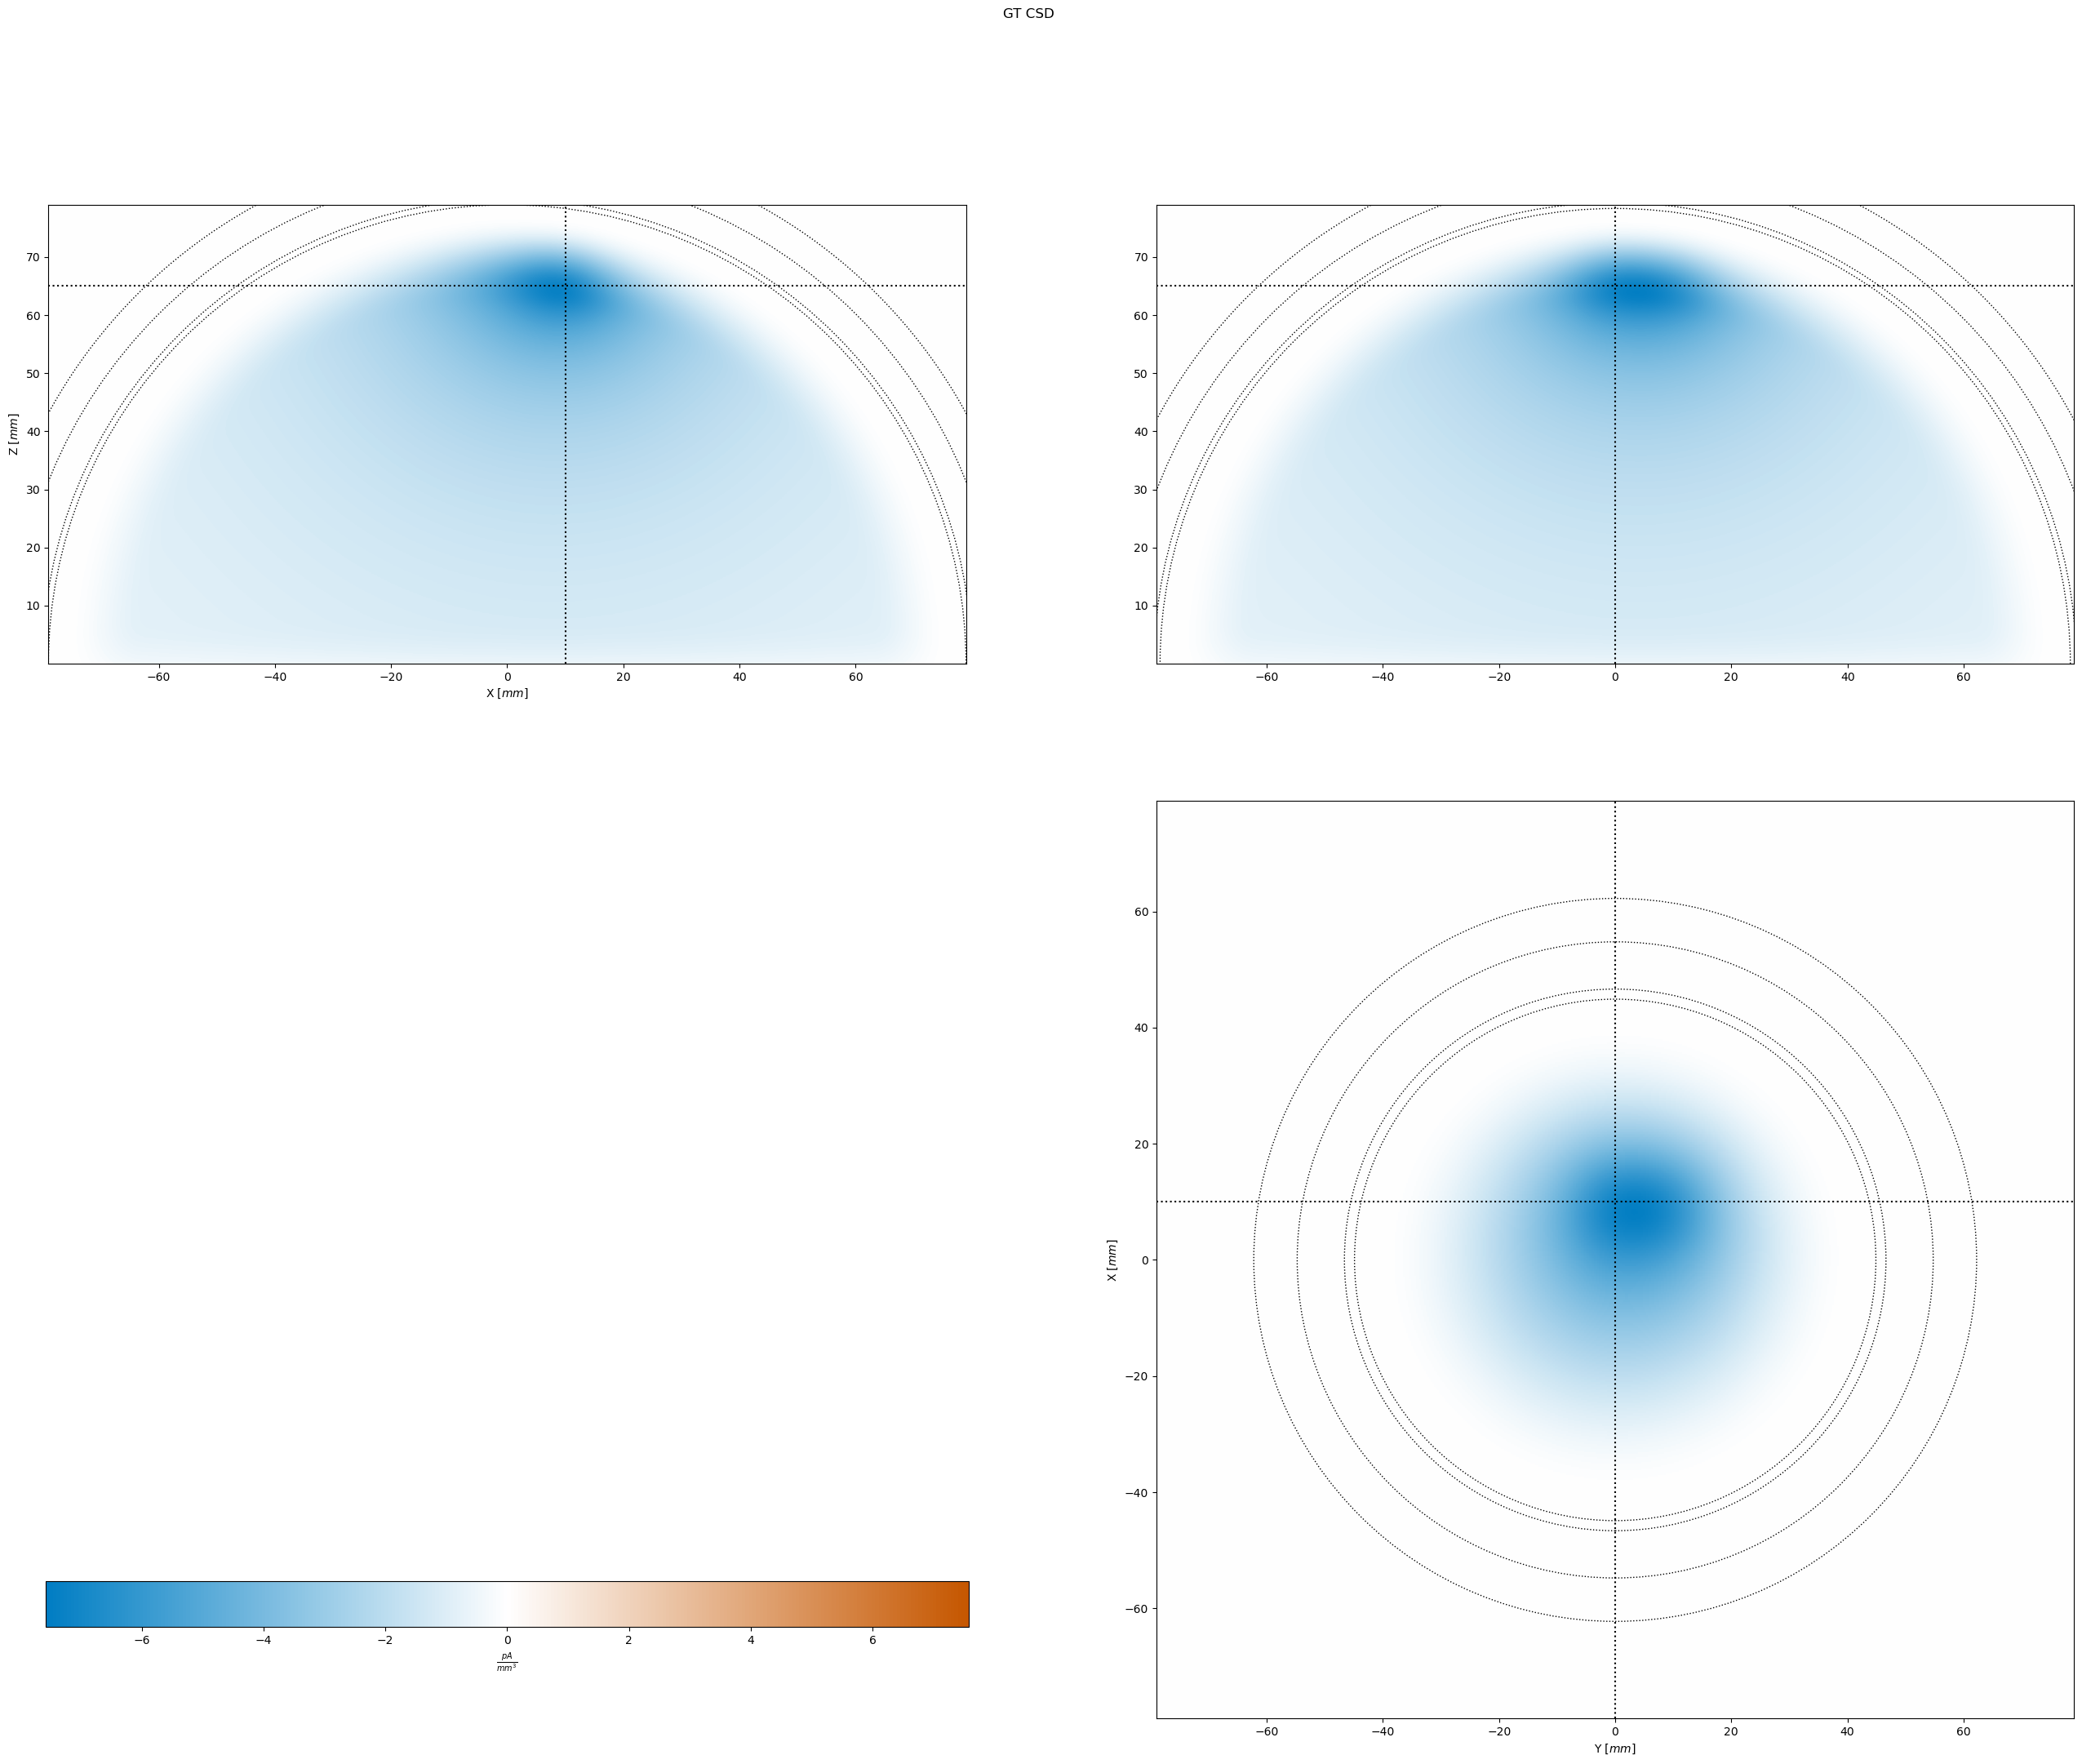

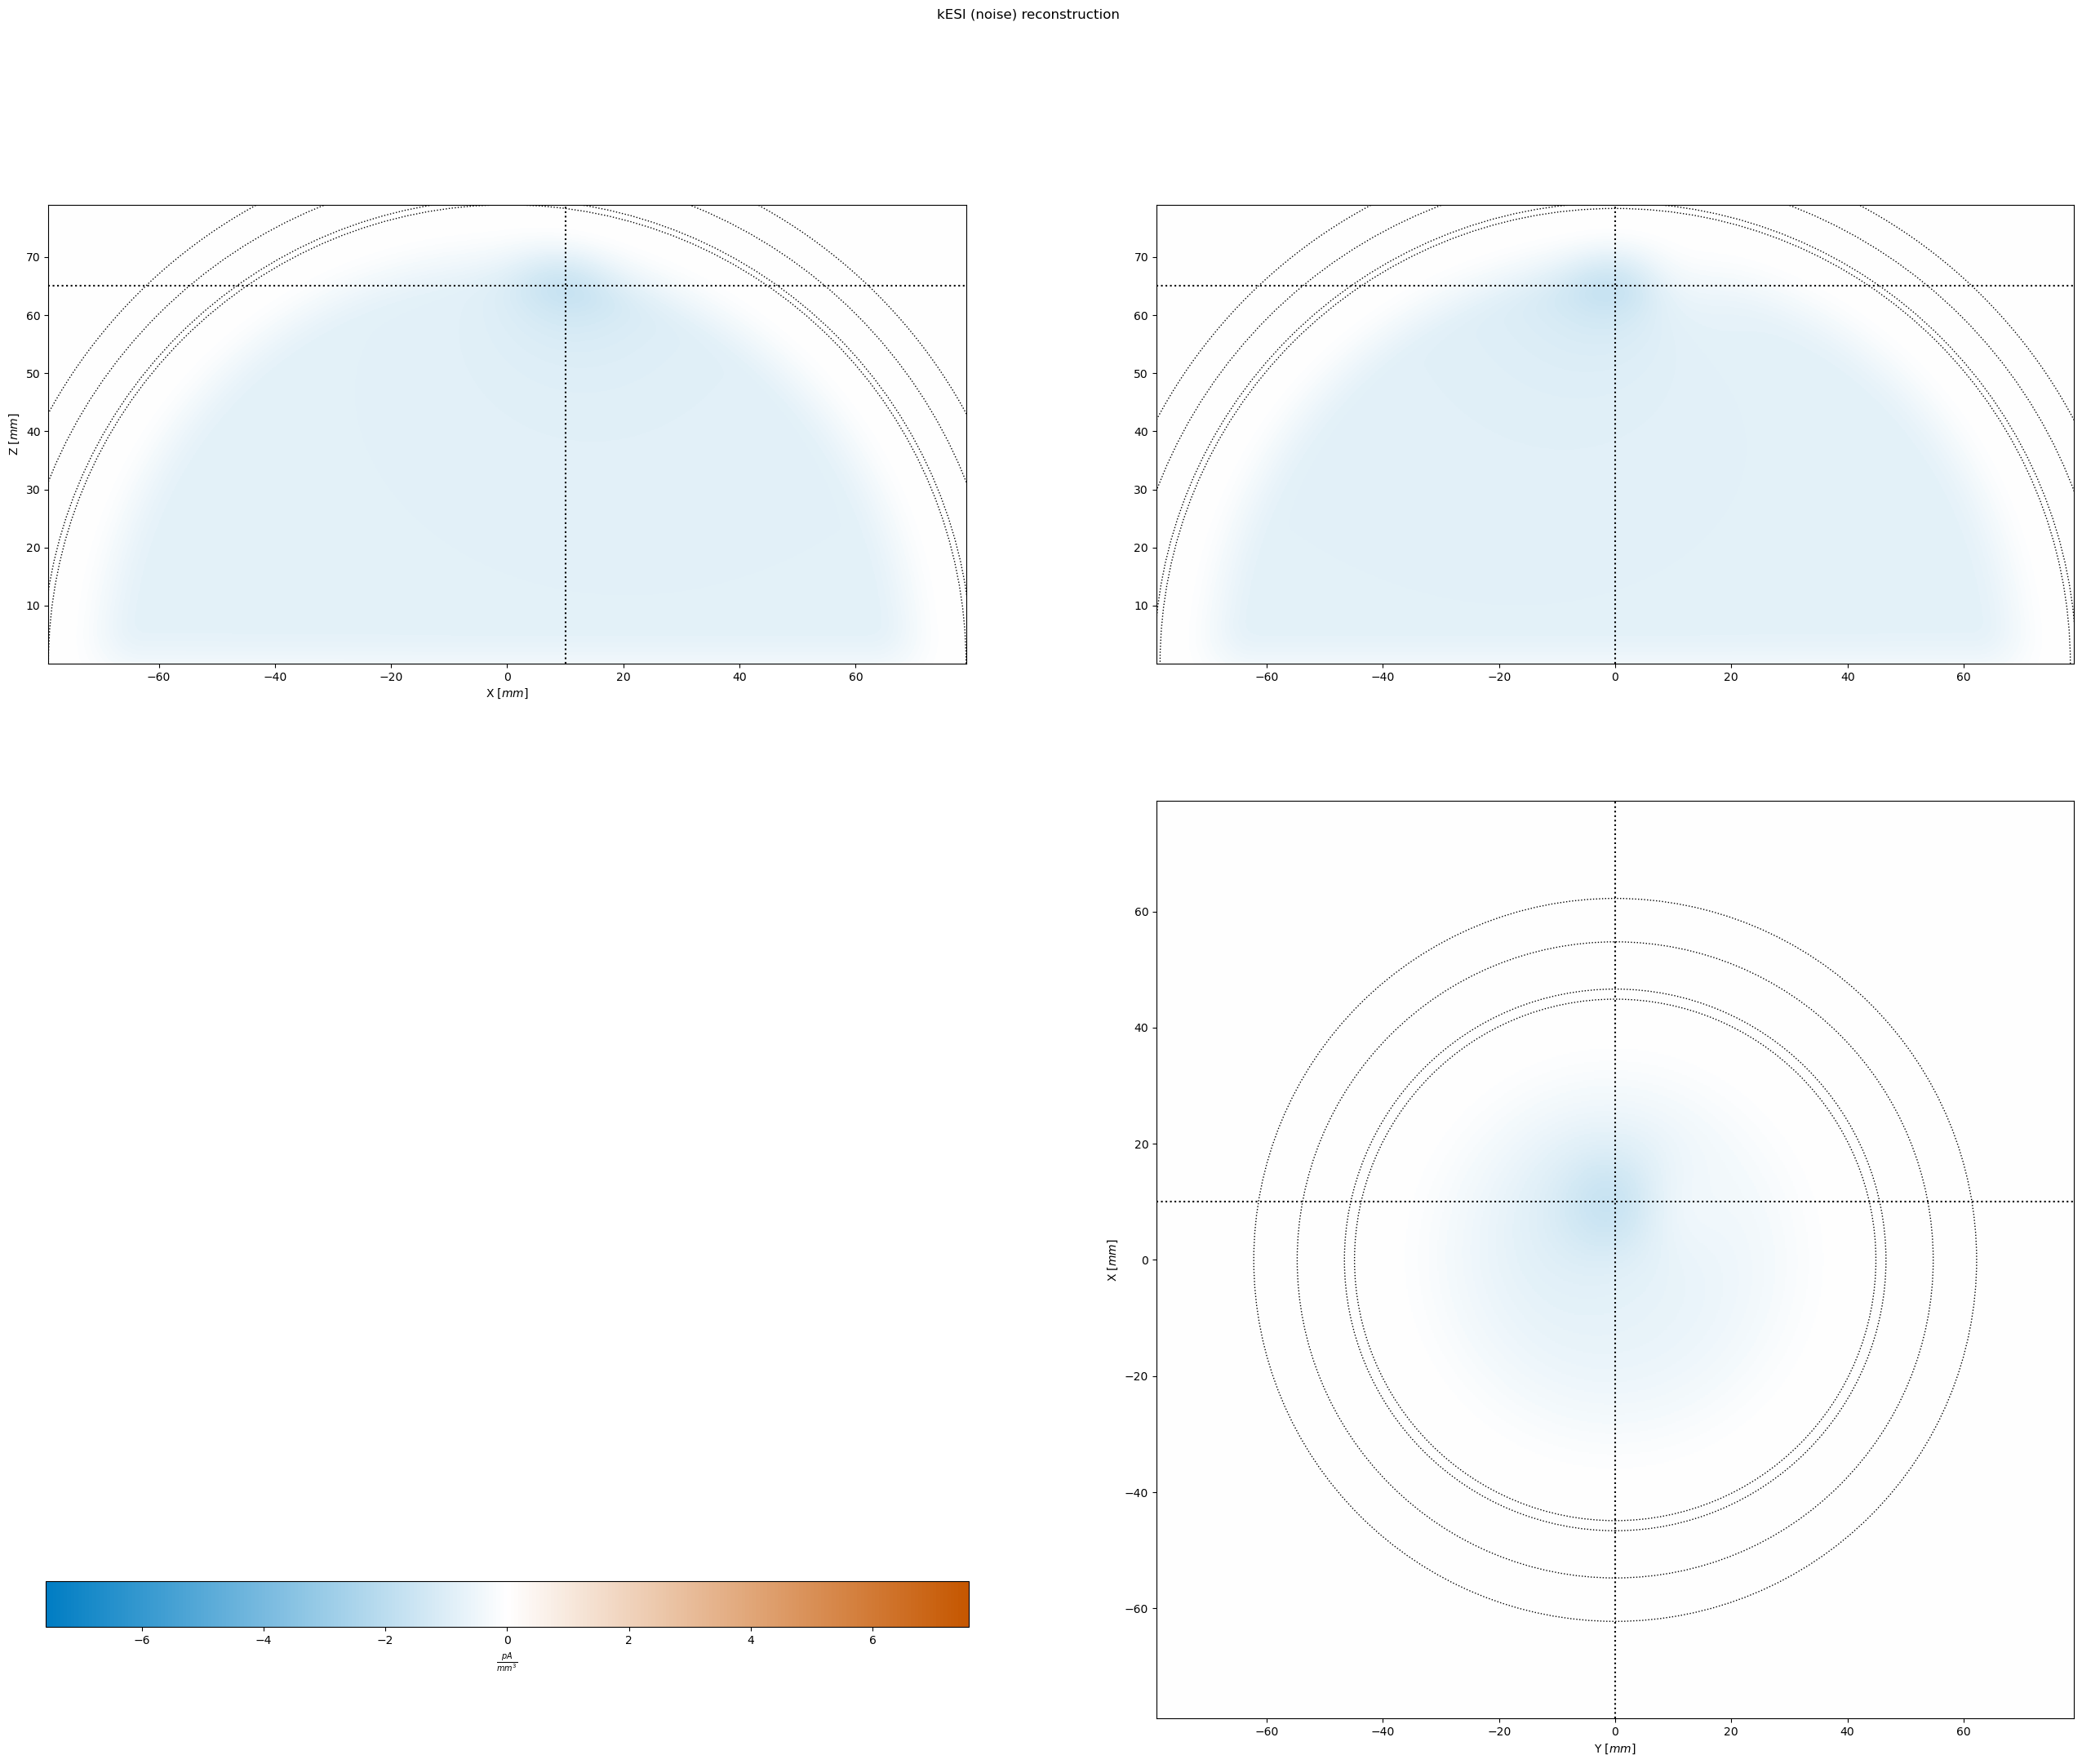

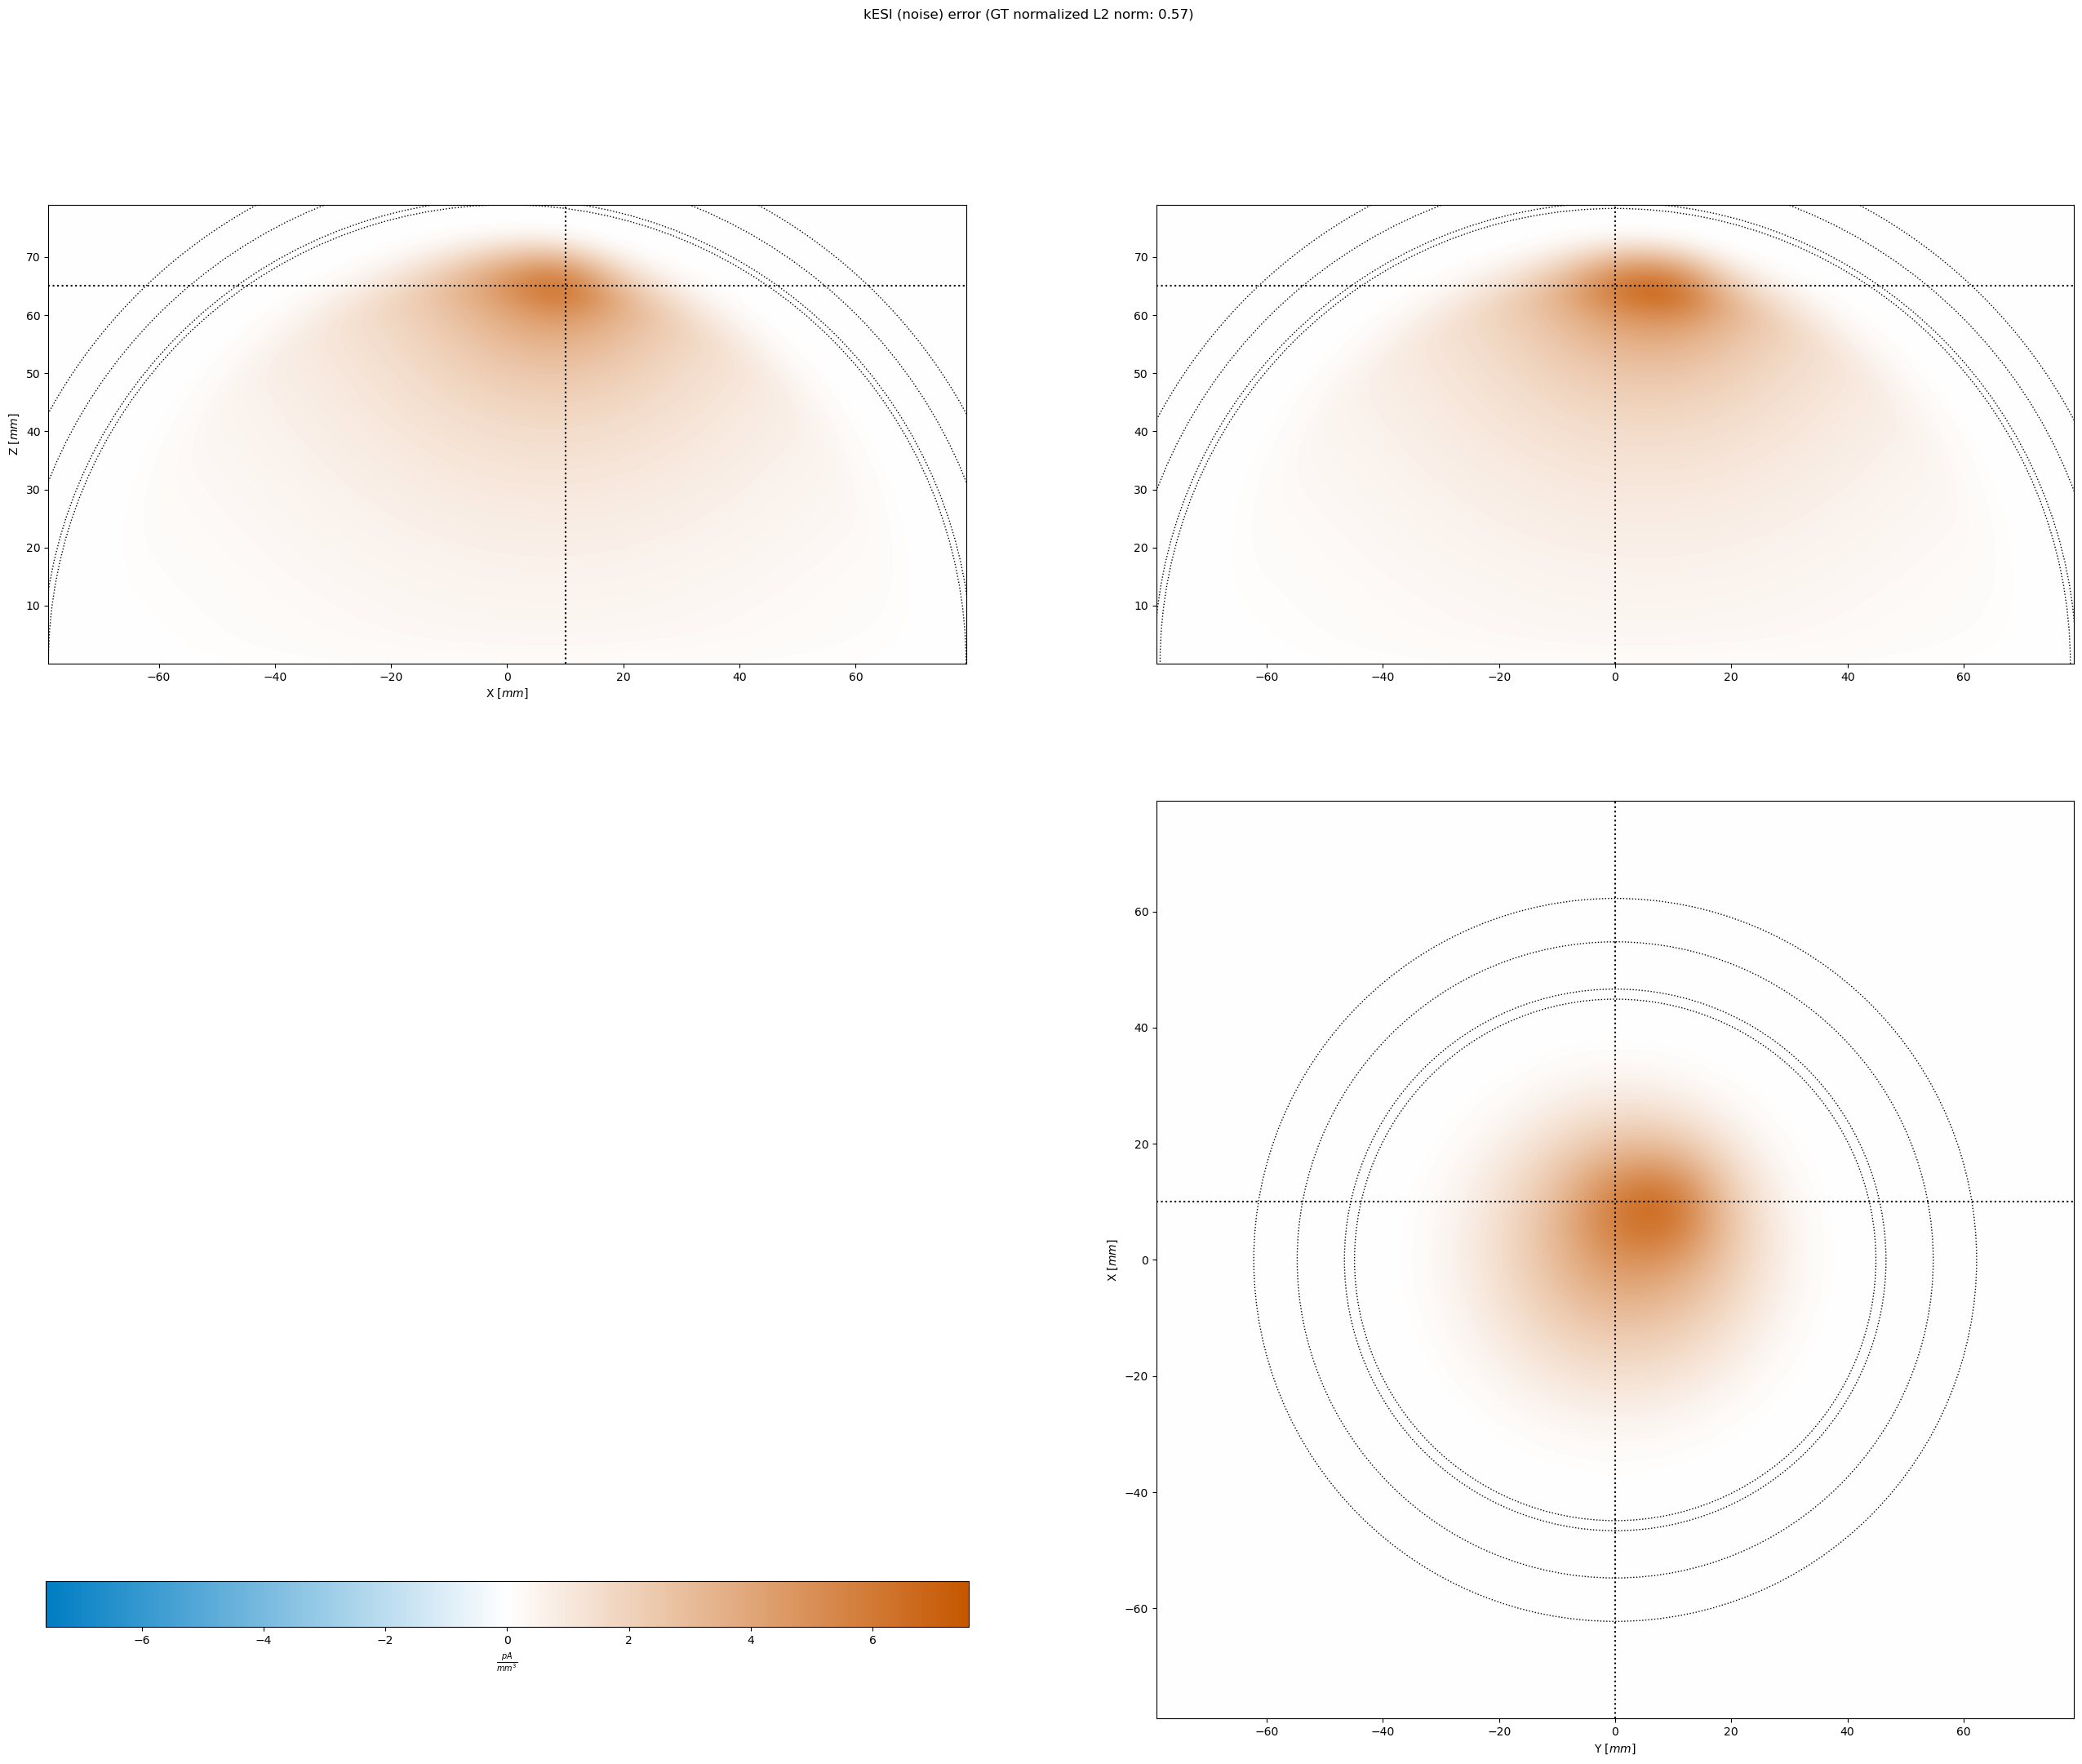

In [60]:
csd_plotter.compare_with_gt(GT_CSD,
                            CSD_KESI_CV,
                            'kESI (noise)')

In [61]:
del CSD_KESI_CV  # the array is large and no longer needed

### L-curve

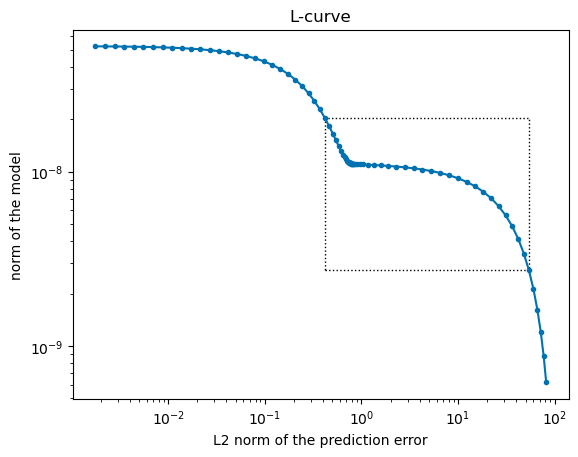

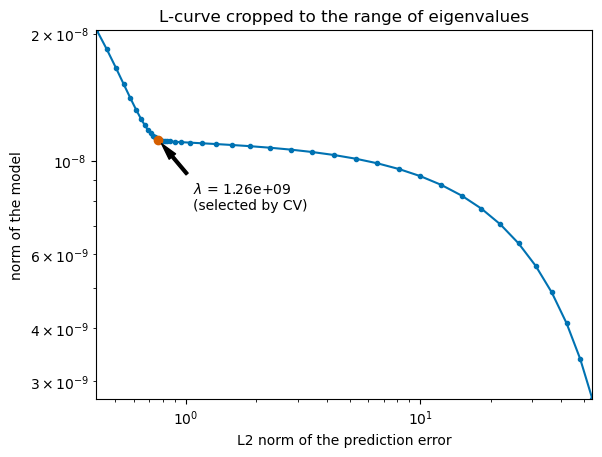

In [62]:
from local.tutorial.view import LCurvePlotter


plot_lcurve = LCurvePlotter(REGULARIZATION_PARAMETERS)
plot_lcurve(KERNEL_KESI, V_WITH_NOISE,
            cv_selected_parameter=regularization_parameter)